# Imports

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit_algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from GraphData import GraphData
import random

In [2]:
import networkx.algorithms.approximation.maxcut as maxcut
from QAOACircuit import QAOACircuit
from QAOASimulation import QAOASimulation, SimType

# Build Random Graph

In [3]:
# Build random graph, add edges between vertex pairs with probability input
def build_graph_with_probability(num_vertices, probability):
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1")

    G = nx.Graph()
    G.add_nodes_from(range(num_vertices))   # Add vertices

    for i in range( num_vertices ):
        for j in range(i + 1, num_vertices ):
            if random.random() < probability:
                G.add_edge(i, j)  # Add edge with probability

    return G

In [4]:
# TODO: Define for two other graphs types
# Define a list of nx graphs with different layers and probabilities
graph_objs = []
for layers in range(1, 8, 2):
    for probability in np.arange(0.1, 1.1, 0.15):
        graph = build_graph_with_probability(7, probability)
        graph_objs.append(GraphData(graph, layers, probability))


In [5]:
valid_graph_objs = []
removed_graph_objs = []
cut_values = {}

for graph_obj in graph_objs:
    cut_value, partition = maxcut.one_exchange(graph_obj.graph)
    
    if all(len(part) > 0 for part in partition):
        valid_graph_objs.append(graph_obj)
        cut_values[graph_obj.name] = cut_value  # Store the cut value
        print(f"{graph_obj.name}, Cut Value: {cut_value}, Partition: {partition}")
    else:
        removed_graph_objs.append(graph_obj)

graph_objs = valid_graph_objs

for removed_obj in removed_graph_objs:
    print(f"Removed: {removed_obj.name}")


Graph #Layers=1, probability=0.10, Cut Value: 4, Partition: ({1, 6}, {0, 2, 3, 4, 5})
Graph #Layers=1, probability=0.25, Cut Value: 3, Partition: ({0, 1}, {2, 3, 4, 5, 6})
Graph #Layers=1, probability=0.40, Cut Value: 8, Partition: ({0, 1, 3, 6}, {2, 4, 5})
Graph #Layers=1, probability=0.55, Cut Value: 8, Partition: ({1, 3}, {0, 2, 4, 5, 6})
Graph #Layers=1, probability=0.70, Cut Value: 10, Partition: ({0, 3, 4}, {1, 2, 5, 6})
Graph #Layers=1, probability=0.85, Cut Value: 12, Partition: ({2, 3, 6}, {0, 1, 4, 5})
Graph #Layers=1, probability=1.00, Cut Value: 12, Partition: ({0, 1, 3}, {2, 4, 5, 6})
Graph #Layers=3, probability=0.10, Cut Value: 1, Partition: ({0}, {1, 2, 3, 4, 5, 6})
Graph #Layers=3, probability=0.25, Cut Value: 3, Partition: ({1, 5}, {0, 2, 3, 4, 6})
Graph #Layers=3, probability=0.40, Cut Value: 10, Partition: ({0, 4, 6}, {1, 2, 3, 5})
Graph #Layers=3, probability=0.55, Cut Value: 8, Partition: ({1, 3, 5}, {0, 2, 4, 6})
Graph #Layers=3, probability=0.70, Cut Value: 10, 

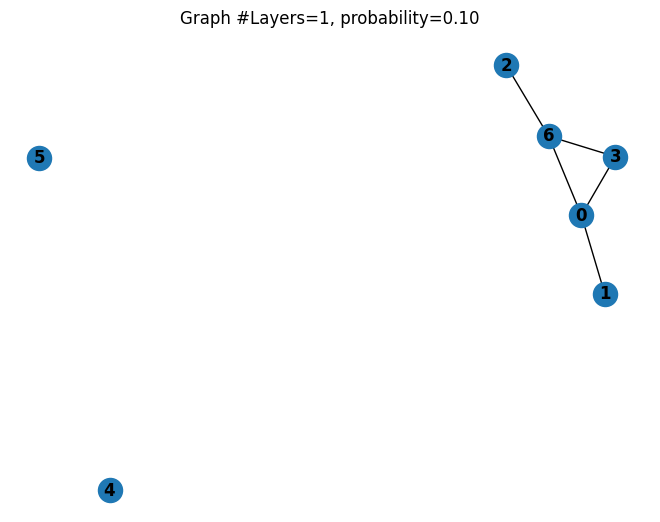

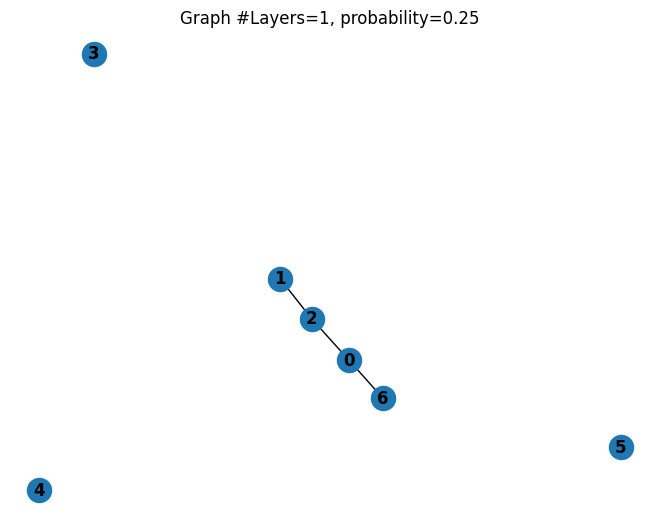

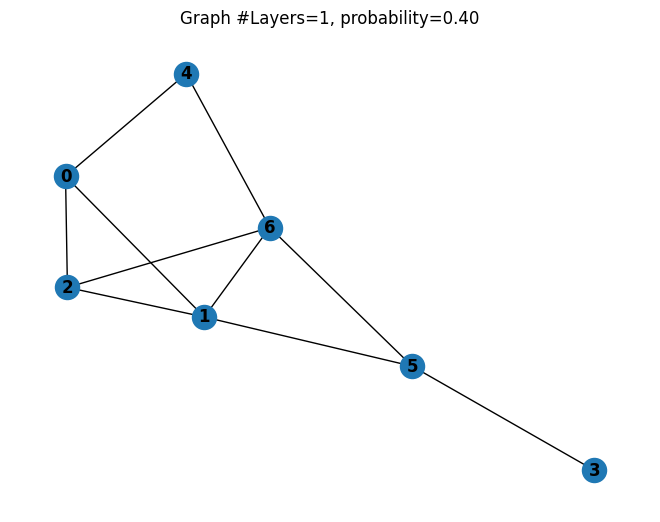

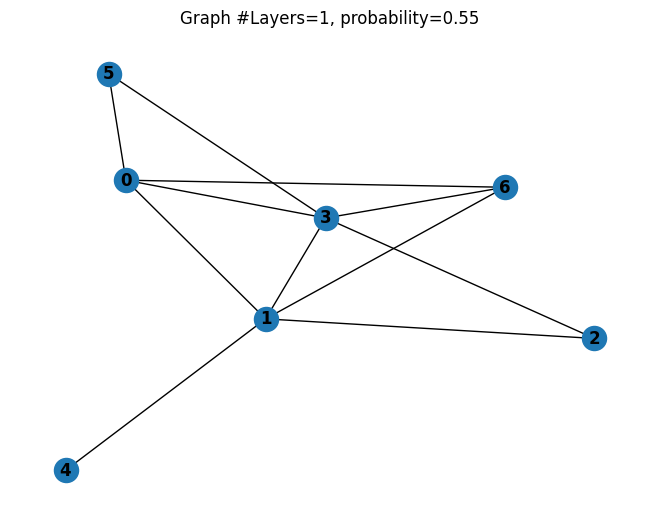

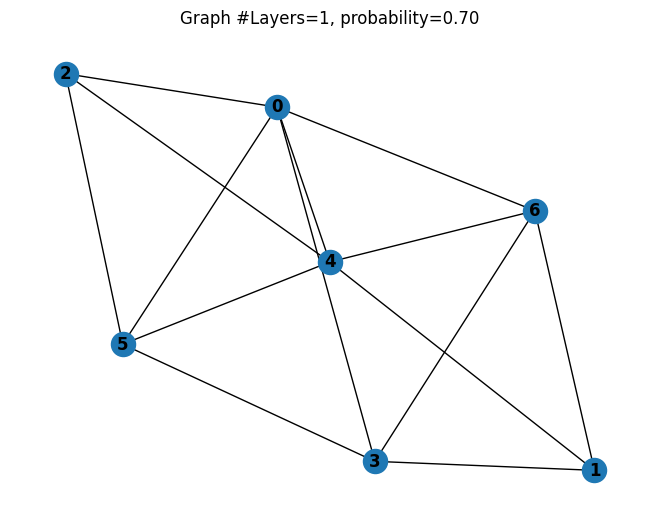

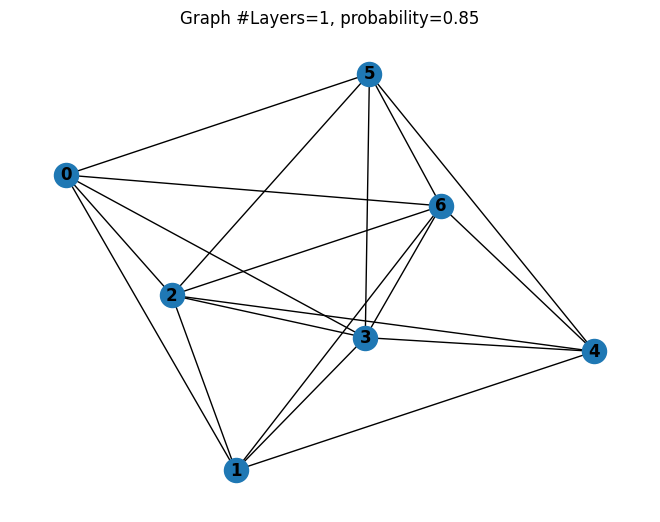

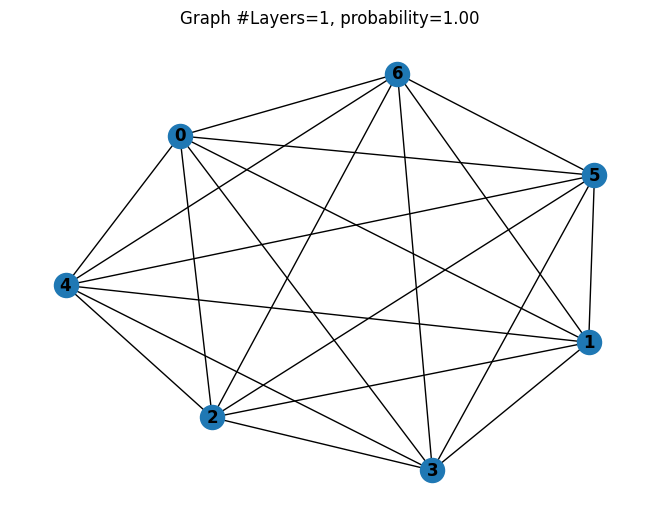

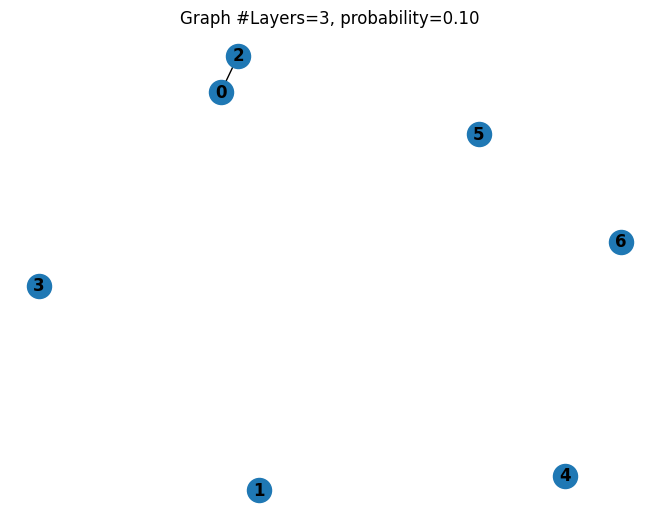

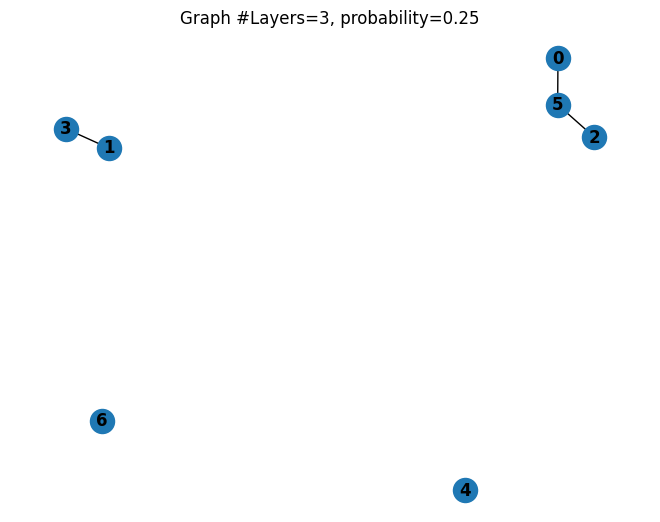

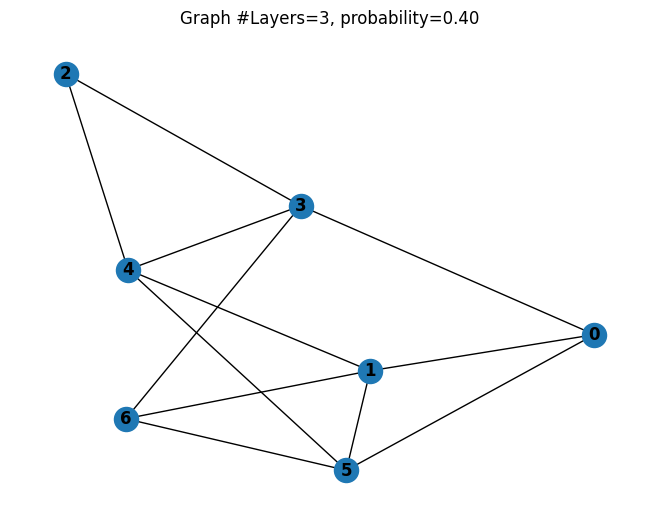

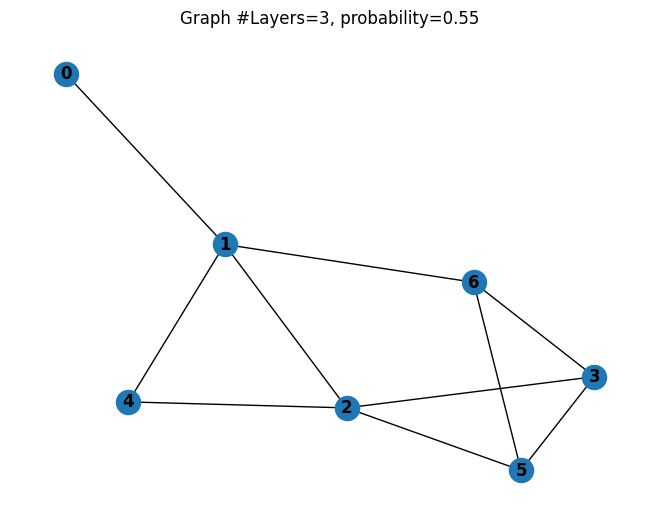

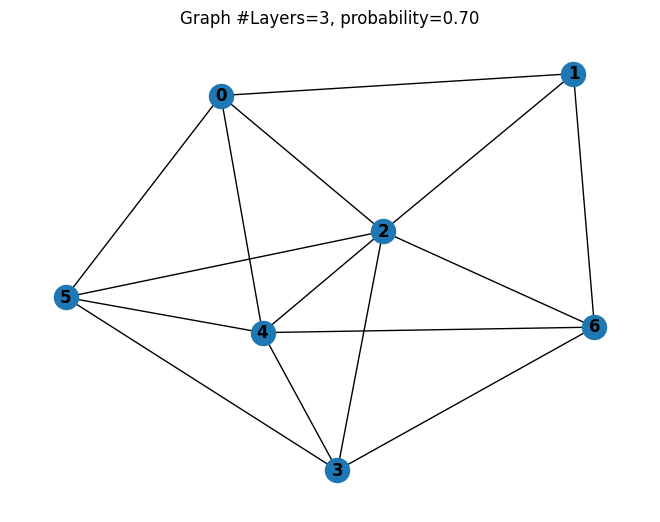

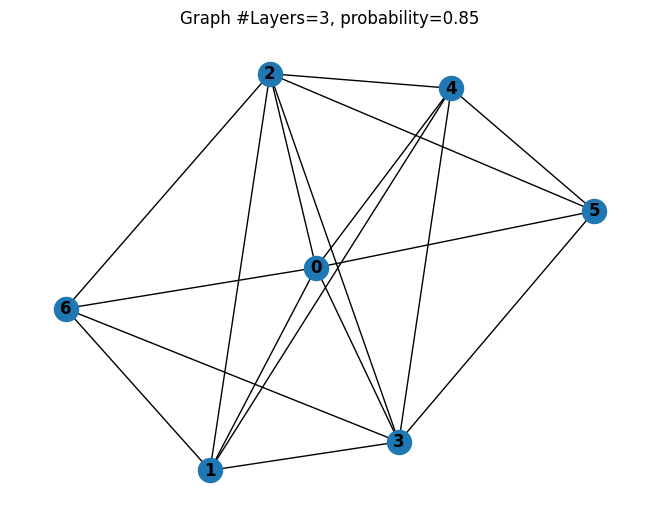

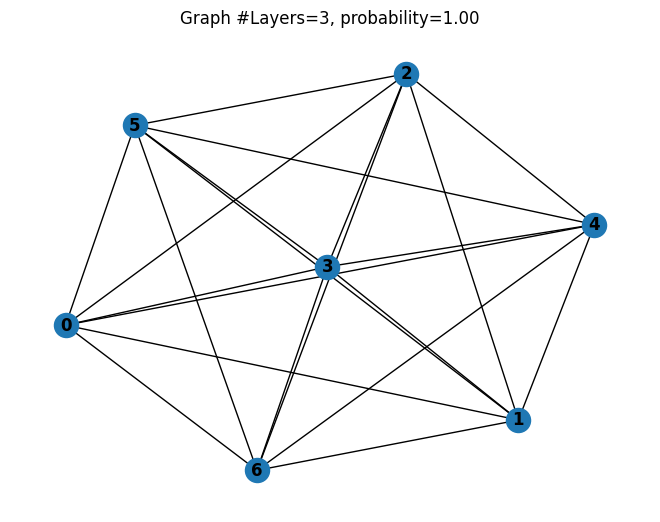

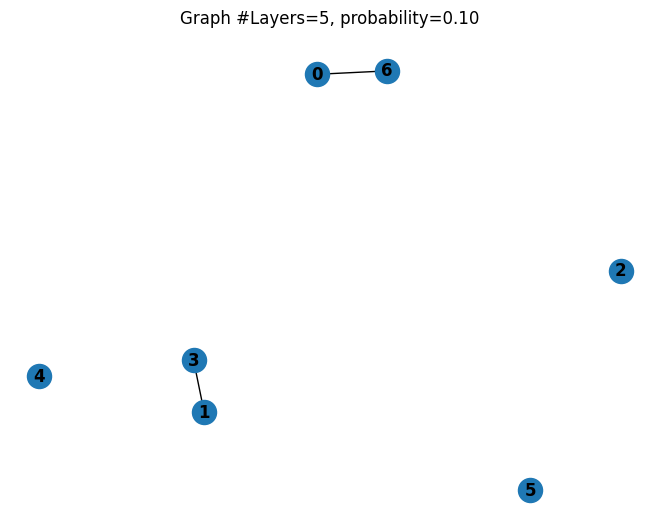

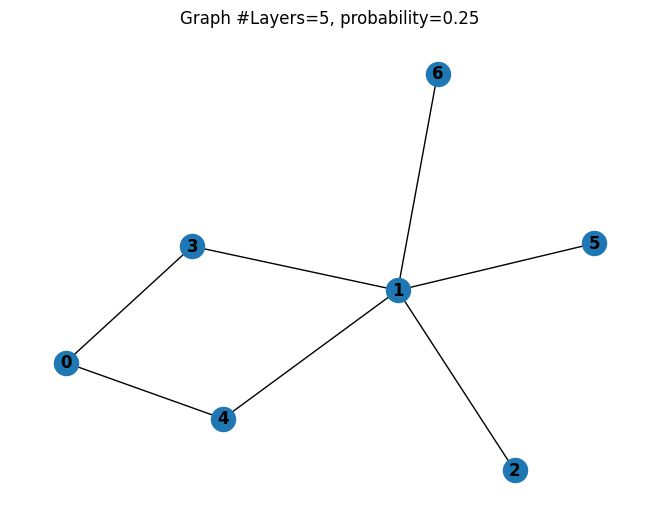

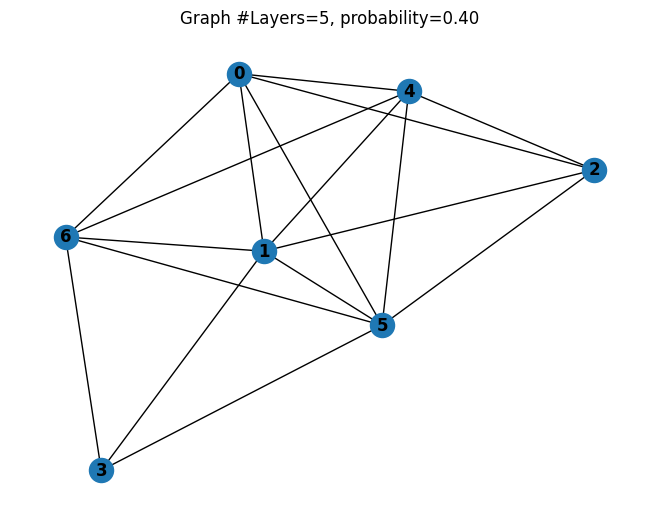

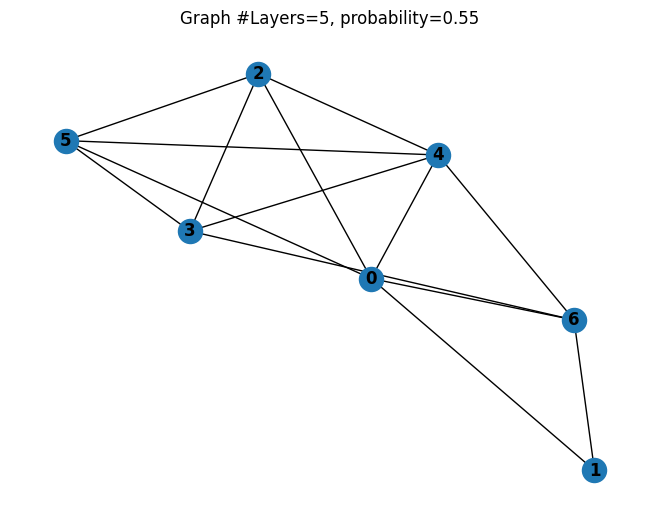

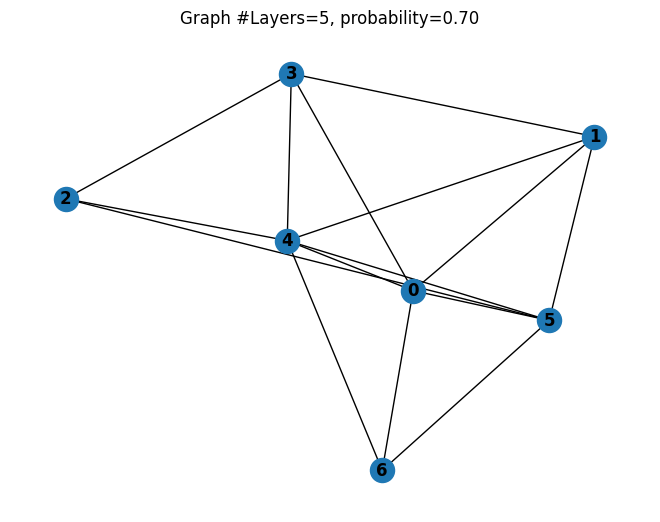

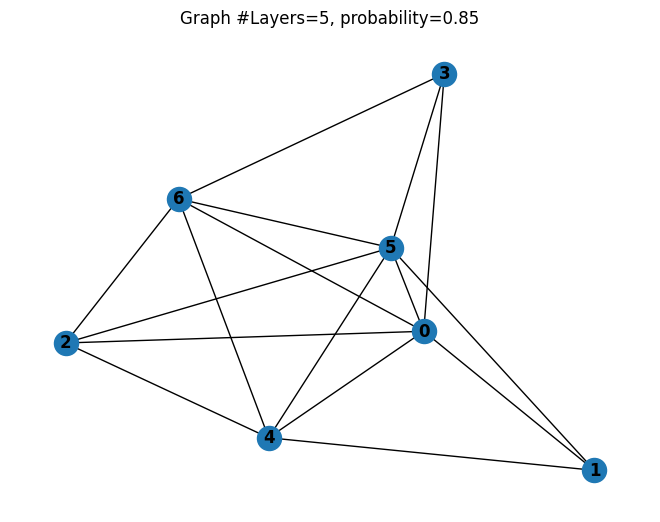

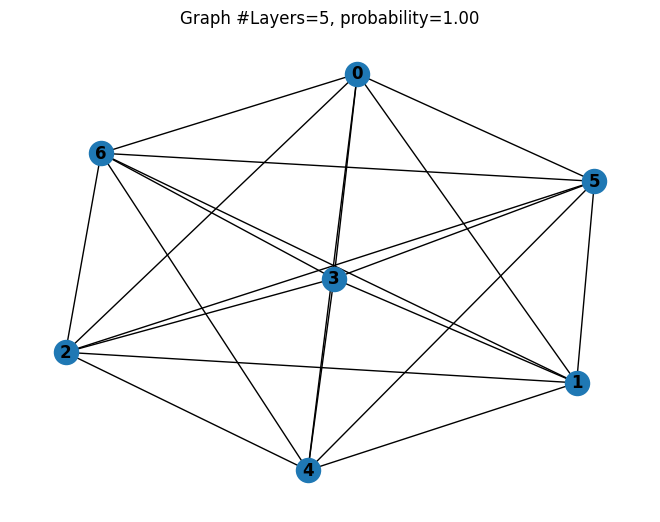

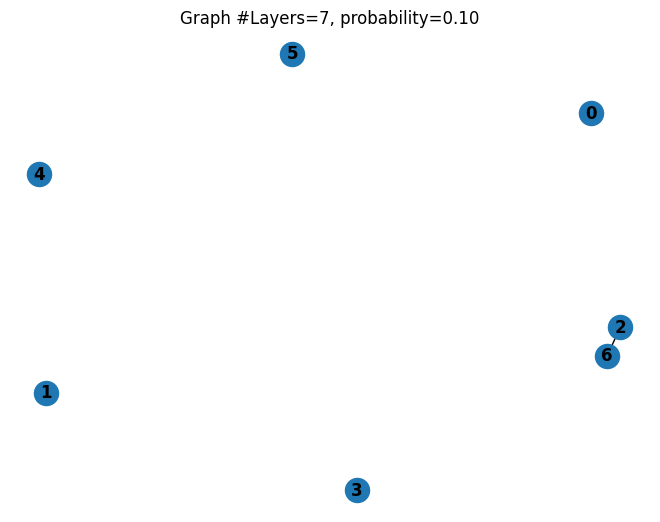

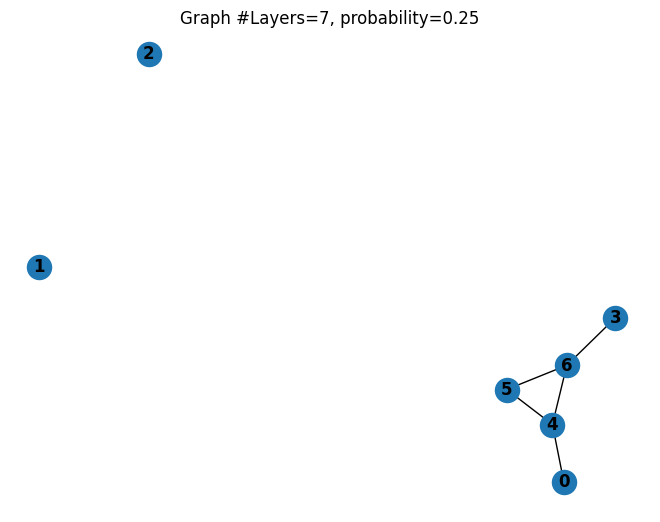

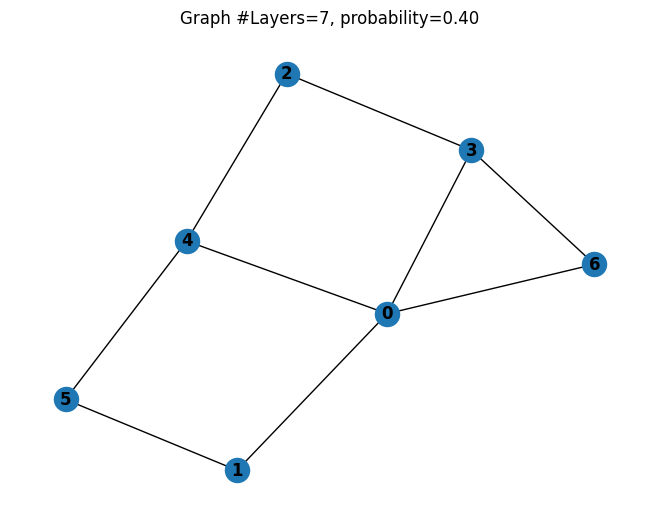

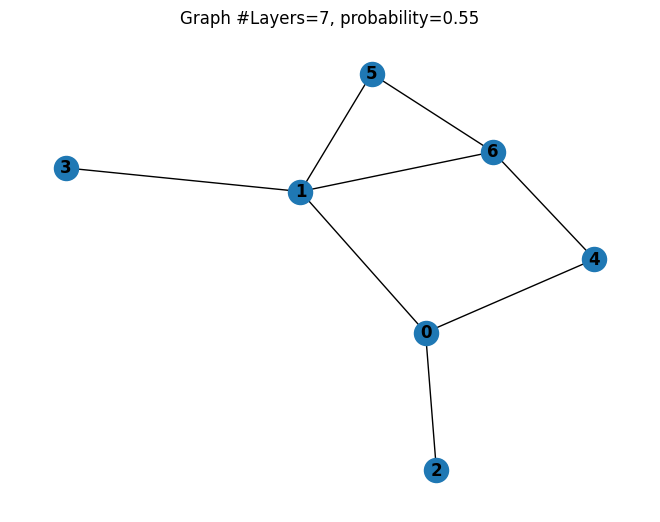

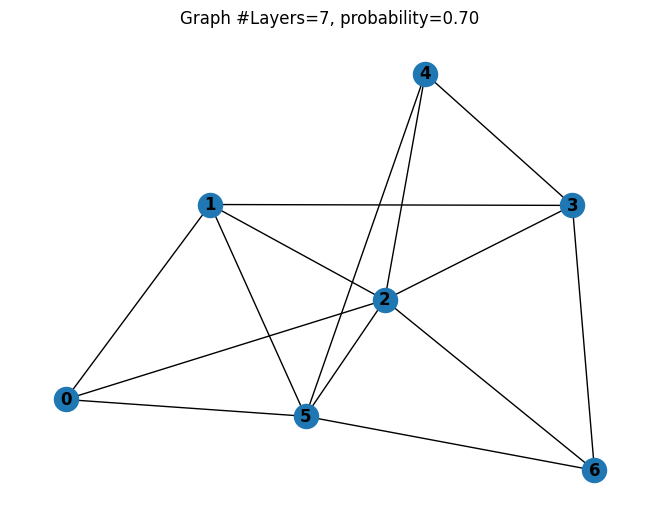

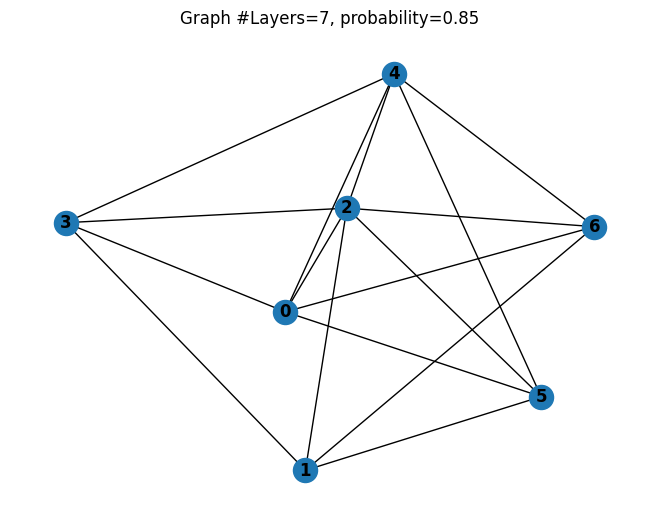

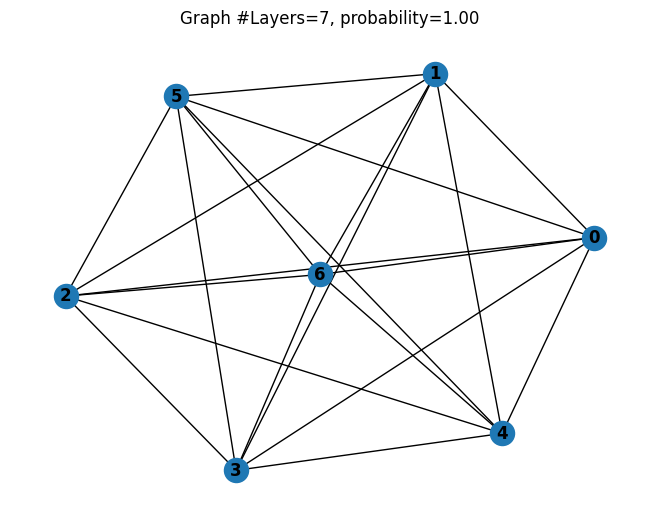

In [6]:
# TODO: Colorize by cut/no-cut

import matplotlib.pyplot as plt
import networkx as nx

for graph_obj in graph_objs:
    nx.draw(graph_obj.graph, with_labels=True, font_weight='bold')
    plt.title(graph_obj.name)
    plt.show()


# Attempt at calling simulator object (STATE_VECTOR)

In [7]:
sim_sv = QAOASimulation(SimType.STATE_VECTOR)

In [8]:
opt_res_counts_dict = {}  # Create a dictionary to store results

for graph_obj in graph_objs:
    opt_res = sim_sv.get_opt_params(graph_obj, graph_obj.layers)
    opt_res_counts = sim_sv.run_circuit_optimal_params(opt_res, graph_obj, graph_obj.layers)
    opt_res_counts_dict[graph_obj.name] = opt_res_counts

    print(f"Graph: {graph_obj.name}")
    print("Optimal Parameters:", opt_res)
    print("Optimal Results Counts:", opt_res_counts)

# Now opt_res_counts_dict contains the results for each graph_obj



   Normal return from subroutine COBYLA

   NFVALS =  144   F =-3.655518E+00    MAXCV = 0.000000E+00
   X = 5.393567E-01   3.138375E+00   7.841443E-01   2.138442E+00   3.261772E-01
       2.299581E+00   6.125859E+00   2.379484E+00   3.886029E+00   6.298048E+00
       5.989673E+00   2.266517E+00   4.141598E+00   6.114566E+00
Graph: Graph #Layers=1, probability=0.10
Optimal Parameters:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.655517578125
       x: [ 5.394e-01  3.138e+00 ...  4.142e+00  6.115e+00]
    nfev: 144
   maxcv: 0.0
Optimal Results Counts: {'0001110': 2, '1111111': 1, '0000100': 1, '0001000': 3, '0000110': 2, '0011110': 8, '0011010': 8, '1111011': 2, '1110100': 32, '0100010': 9, '1011101': 2, '1110000': 36, '1010001': 9, '0000101': 15, '0011111': 1, '1100011': 10, '1011001': 2, '0010000': 7, '1001111': 6, '1001001': 6, '1010101': 11, '0110010': 9, '1101111': 6, '0101000': 10, '0010110': 9, '1010111': 12, '0100000': 8, '0111111': 15

In [14]:
from tabulate import tabulate

# Find the best solutions for each graph_obj using opt_res_counts
best_solutions = {}
for graph_obj in graph_objs:
    opt_res_counts = opt_res_counts_dict[graph_obj.name]
    best_cut, best_solution = sim_sv.best_solution(graph_obj, opt_res_counts)
    best_solutions[graph_obj.name] = (best_cut, best_solution)

# Prepare data for the table
table_data = []
for graph_obj_name, (best_cut, best_solution) in best_solutions.items():
    table_data.append([graph_obj_name, -best_cut, best_solution])

# Define table headers
headers = ["Graph Name", "Best Cut", "Best Solution"]

# Display table using tabulate
table = tabulate(table_data, headers=headers, tablefmt='grid')
print(table)


+-----------------------------------+------------+-----------------+
| Graph Name                        |   Best Cut |   Best Solution |
+===================================+============+=================+
| Graph #Layers=1, probability=0.10 |          4 |         0101001 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.25 |          3 |         0010111 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.40 |          8 |         1000011 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.55 |          8 |         1001100 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.70 |         10 |         0011100 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.85 |         12 |         0101010 |
+---------------------------------

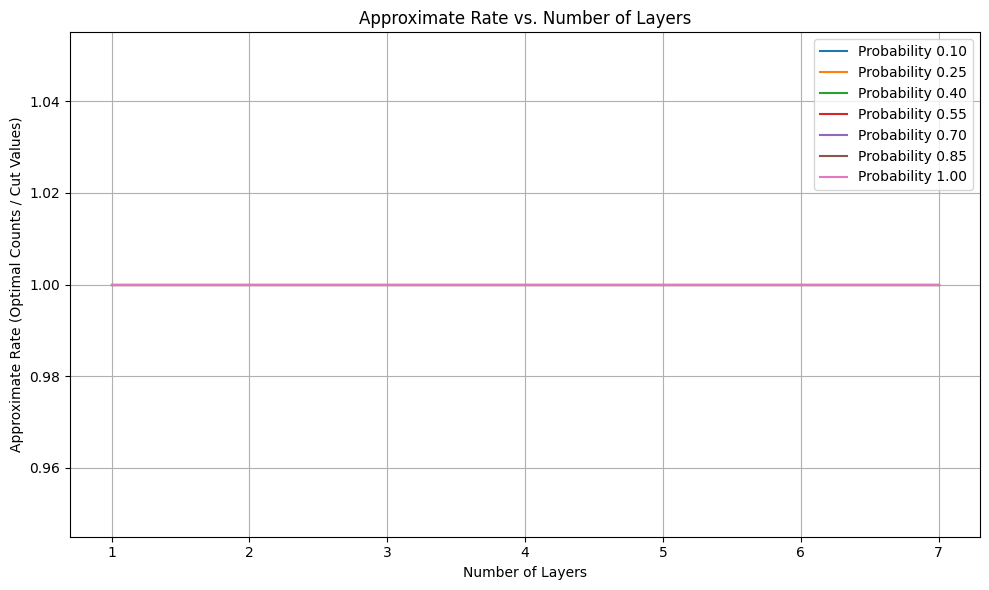

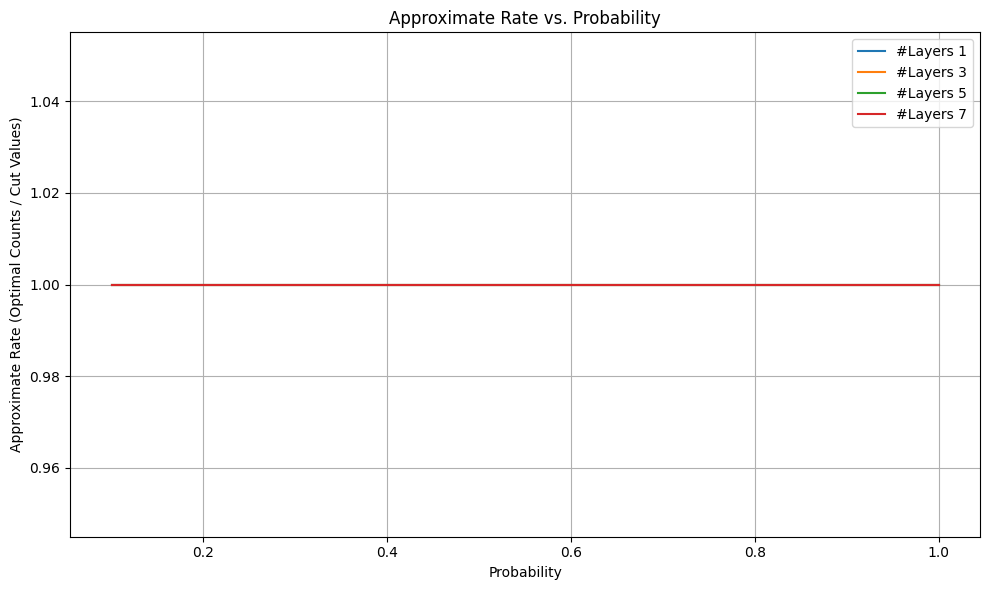

In [15]:
import matplotlib.pyplot as plt

# Separate the data for plotting
approximately_rate_layers_data = {}  # Dictionary to store approximately_rate data per probability
approximately_rate_prob_data = {}  # Dictionary to store approximately_rate data per layer
for graph_obj in graph_objs:
    prob = graph_obj.probability
    layers = graph_obj.layers
    if prob not in approximately_rate_layers_data:
        approximately_rate_layers_data[prob] = []
    if layers not in approximately_rate_prob_data:
        approximately_rate_prob_data[layers] = []
    approximately_rate = -best_solutions[graph_obj.name][0] / cut_values[graph_obj.name]
    approximately_rate_layers_data[prob].append(approximately_rate)
    approximately_rate_prob_data[layers].append(approximately_rate)

# Extract unique layers and probabilities from graph_objs
unique_layers = sorted(set(graph_obj.layers for graph_obj in graph_objs))
unique_probs = sorted(set(graph_obj.probability for graph_obj in graph_objs))

# Plot Approximate Rate vs. Number of Layers
fig1, ax1 = plt.subplots(figsize=(10, 6))
for prob in unique_probs:
    approximately_rate_list = approximately_rate_layers_data[prob]
    ax1.plot(unique_layers[:len(approximately_rate_list)], approximately_rate_list, label=f'Probability {prob:.2f}')
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Approximate Rate (Optimal Counts / Cut Values)')
ax1.set_title('Approximate Rate vs. Number of Layers')
ax1.legend()
ax1.grid(True)
plt.tight_layout()
plt.show()

# Plot Approximate Rate vs. Probability
fig2, ax2 = plt.subplots(figsize=(10, 6))
for layers in unique_layers:
    approximately_rate_list = approximately_rate_prob_data[layers]
    ax2.plot(unique_probs[:len(approximately_rate_list)], approximately_rate_list, label=f'#Layers {layers}')
ax2.set_xlabel('Probability')
ax2.set_ylabel('Approximate Rate (Optimal Counts / Cut Values)')
ax2.set_title('Approximate Rate vs. Probability')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()


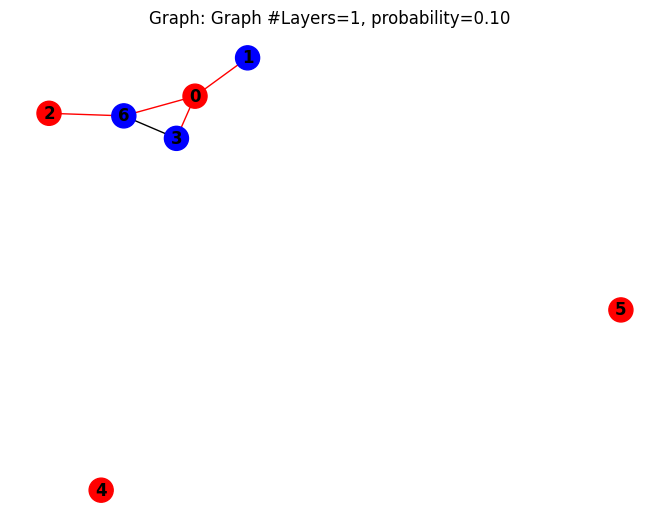

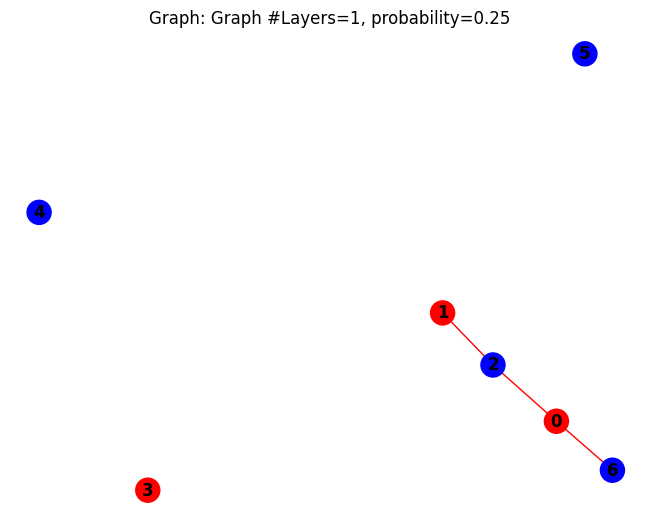

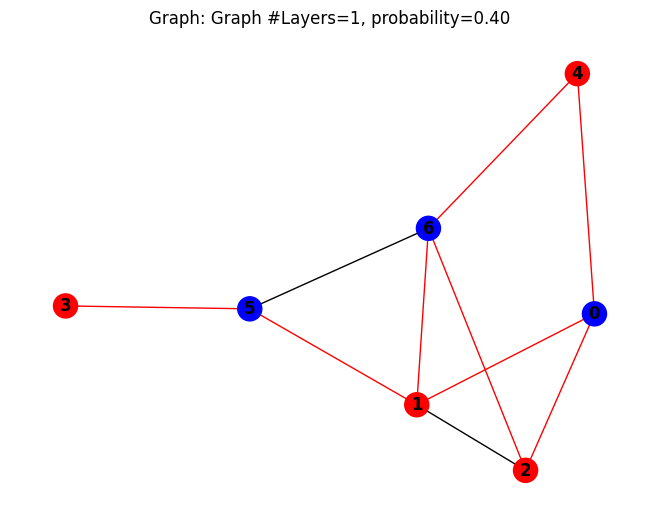

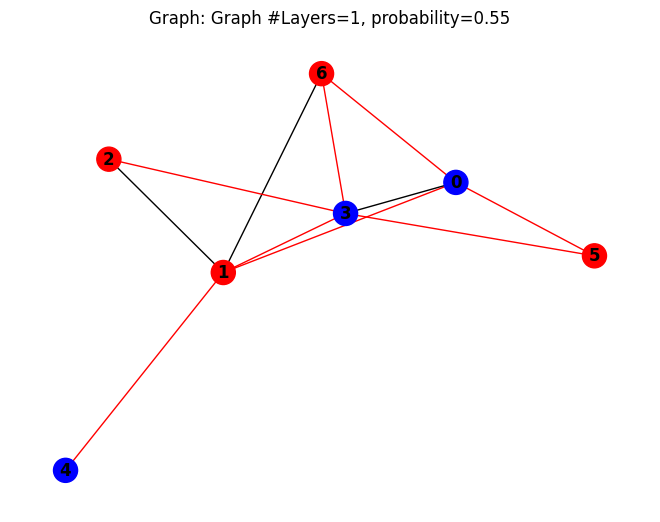

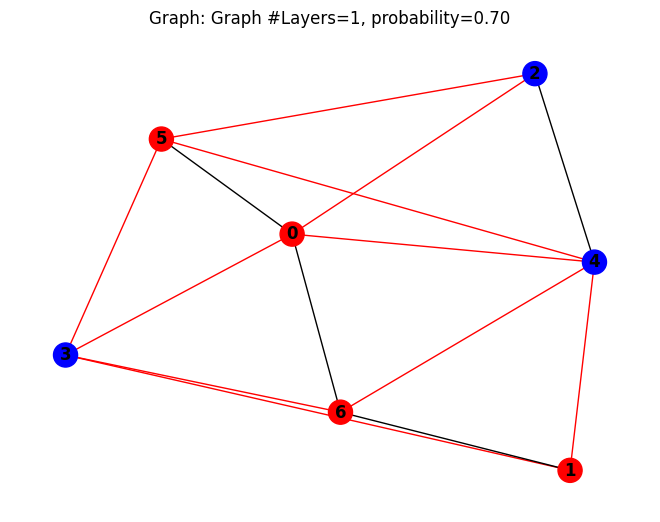

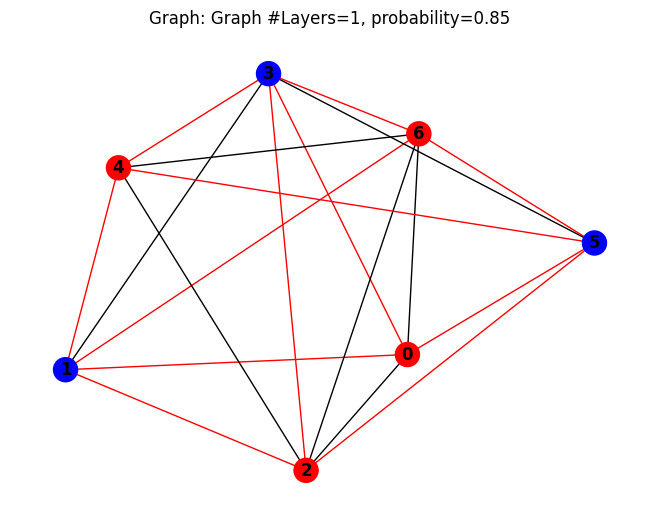

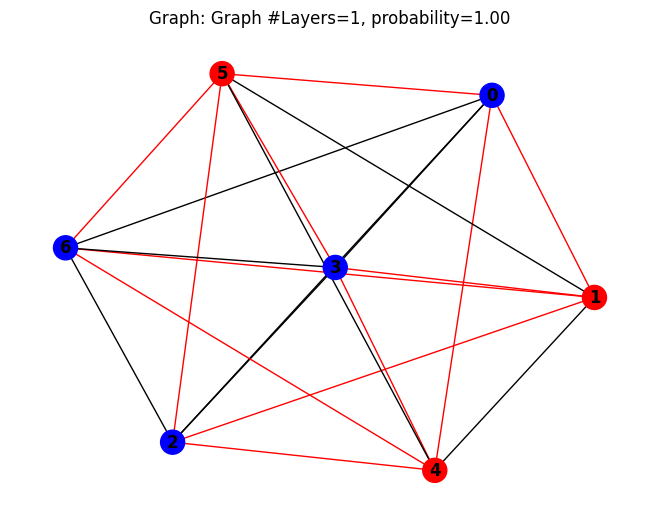

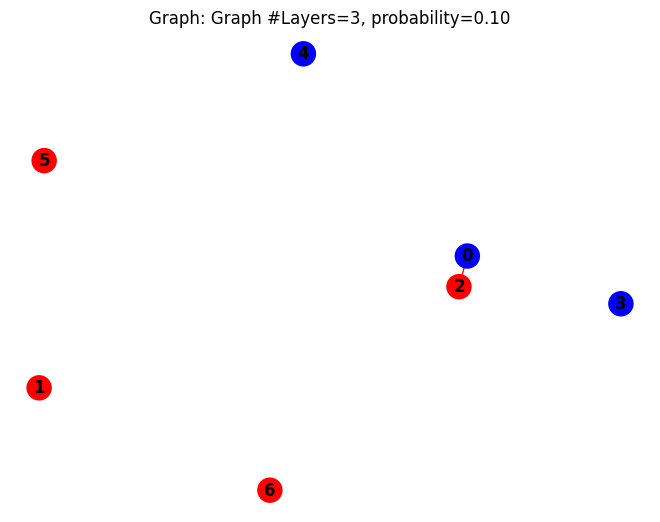

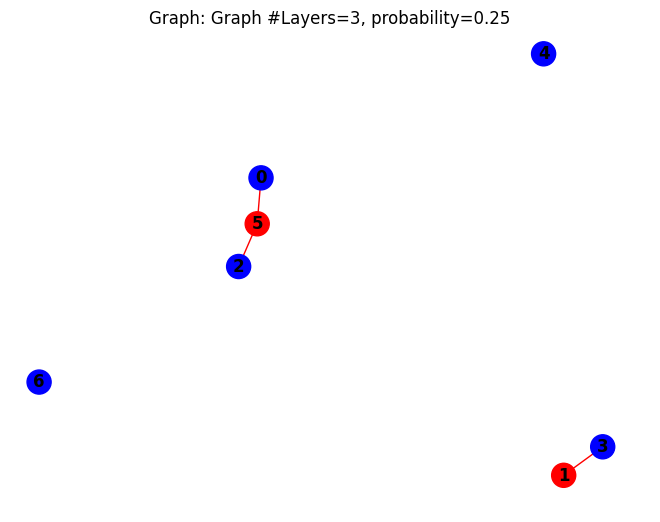

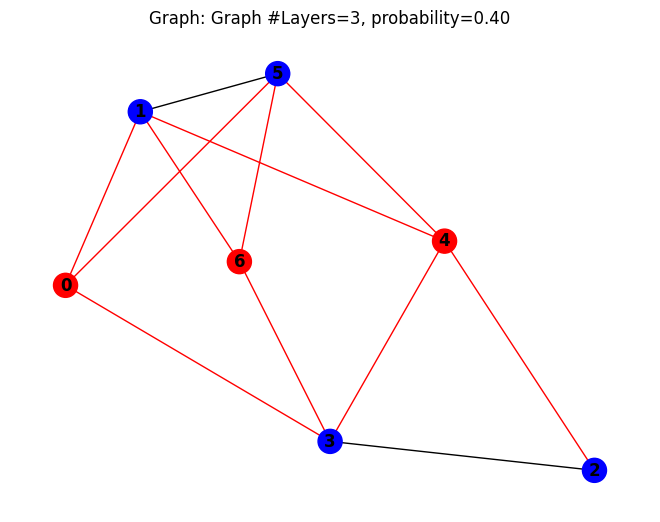

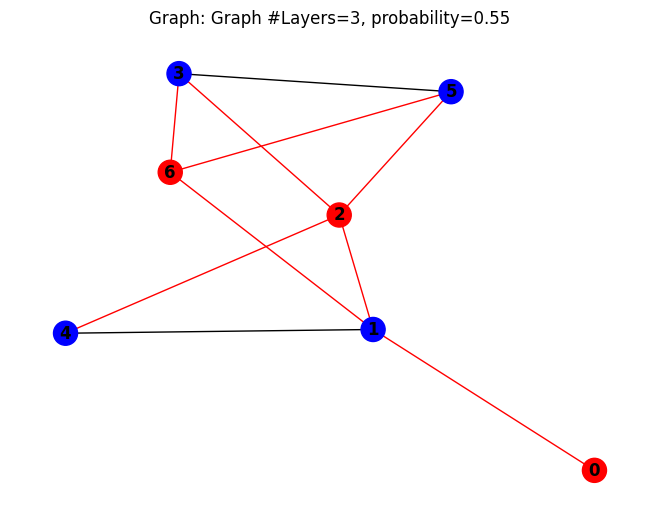

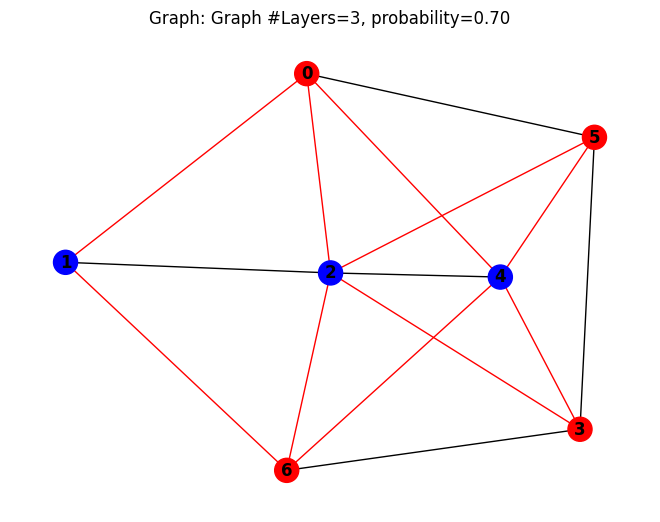

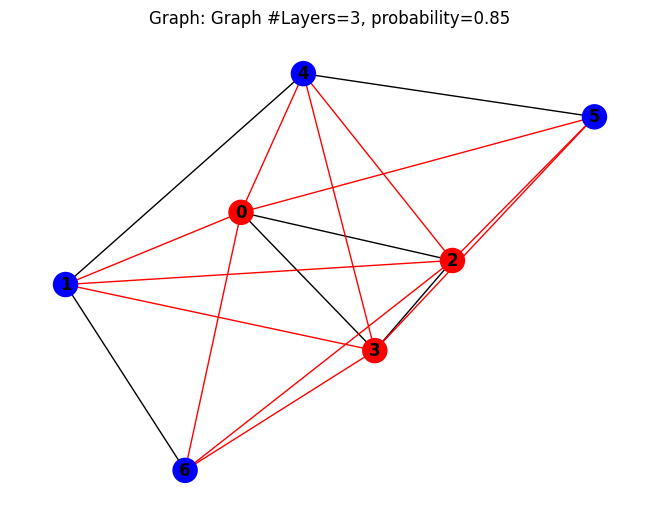

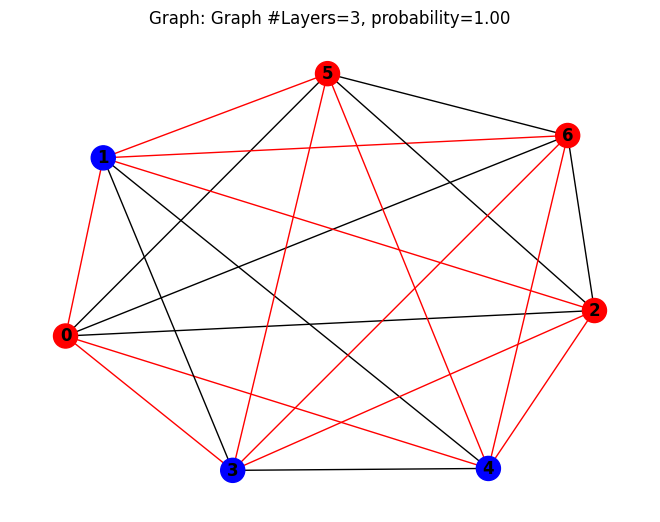

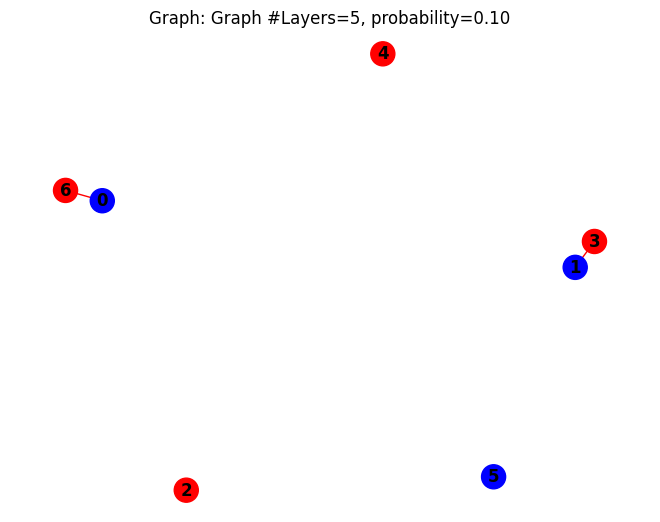

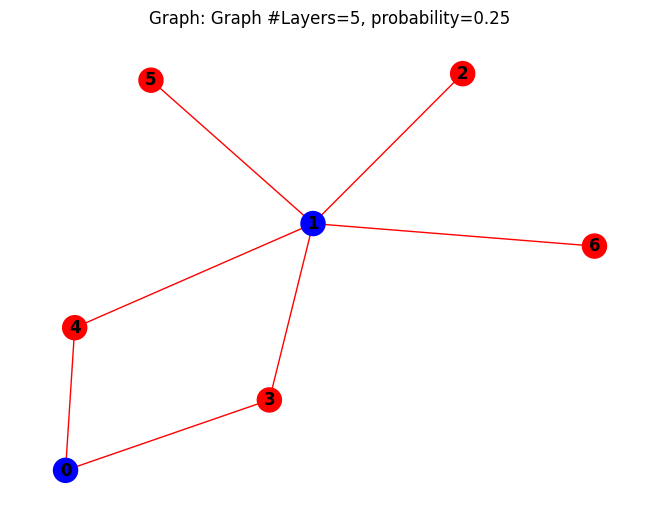

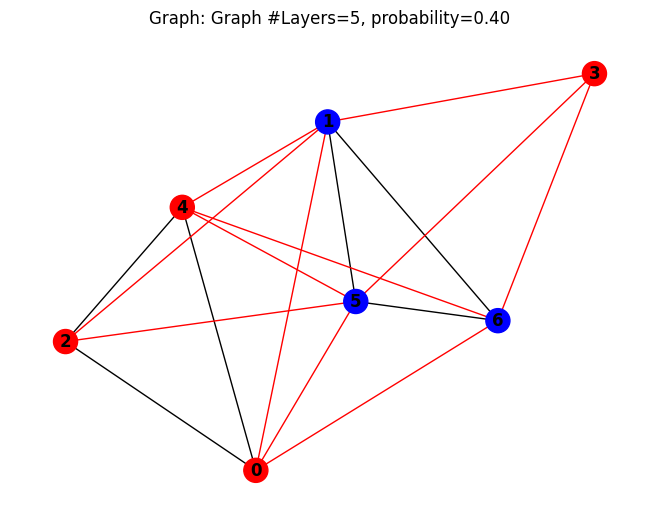

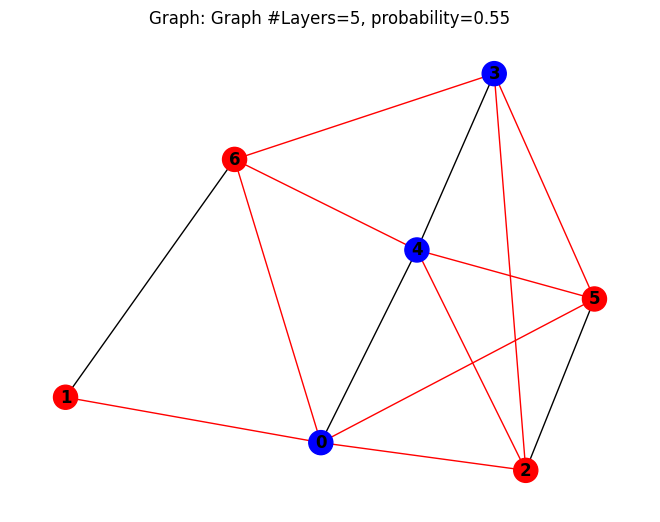

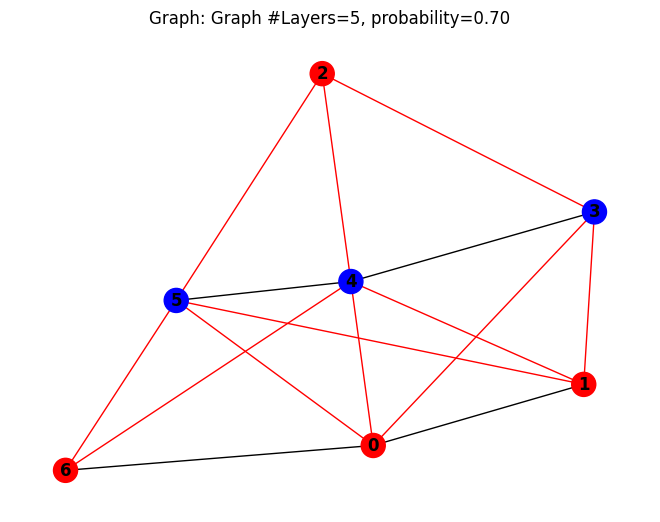

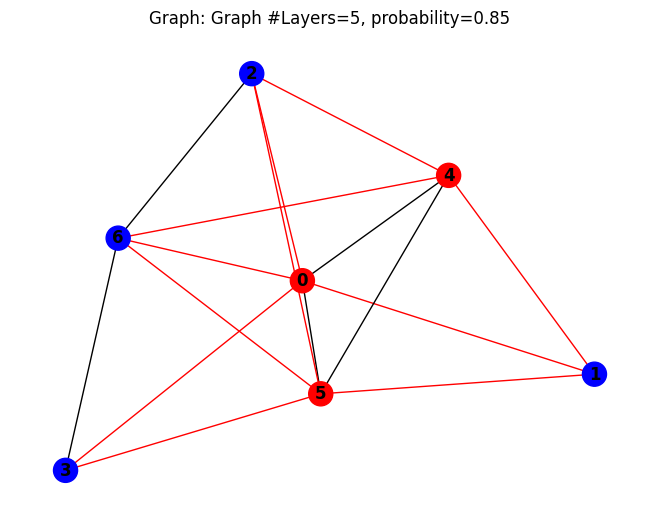

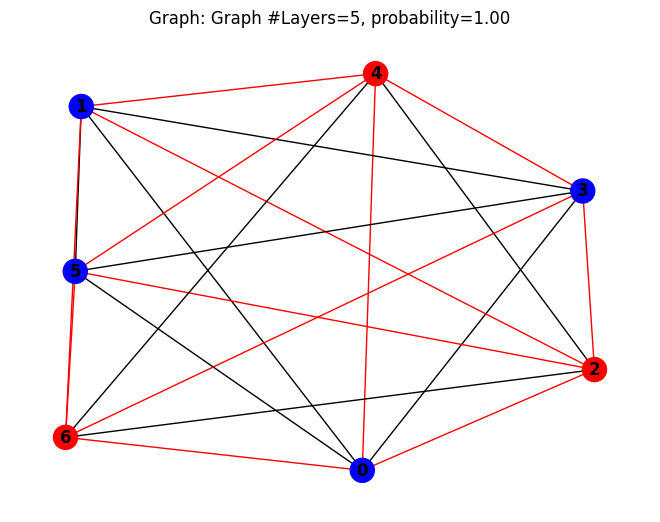

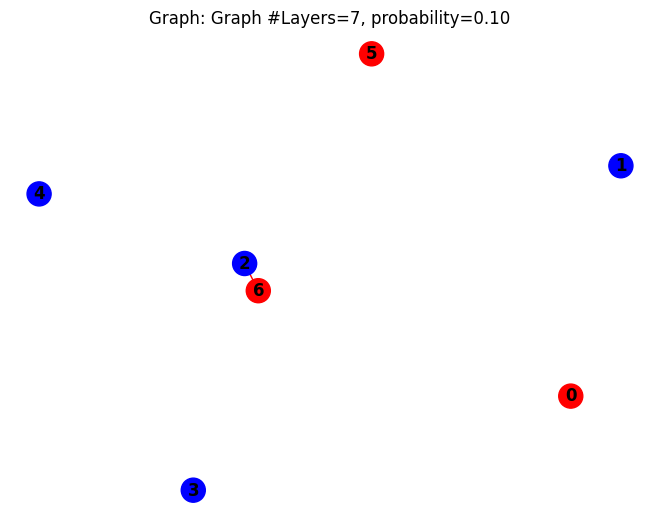

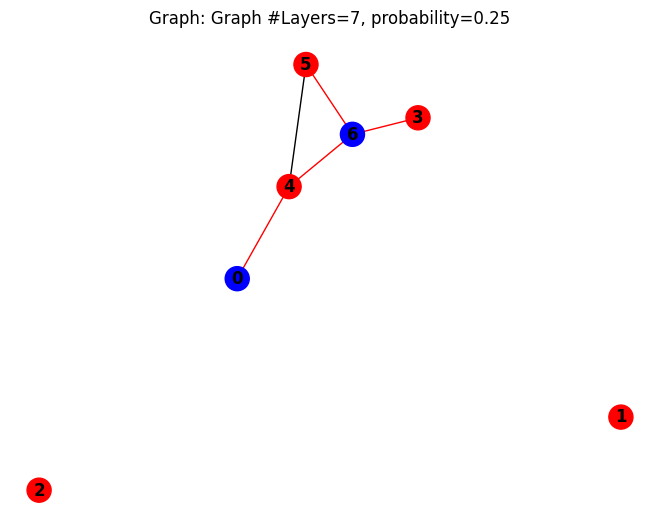

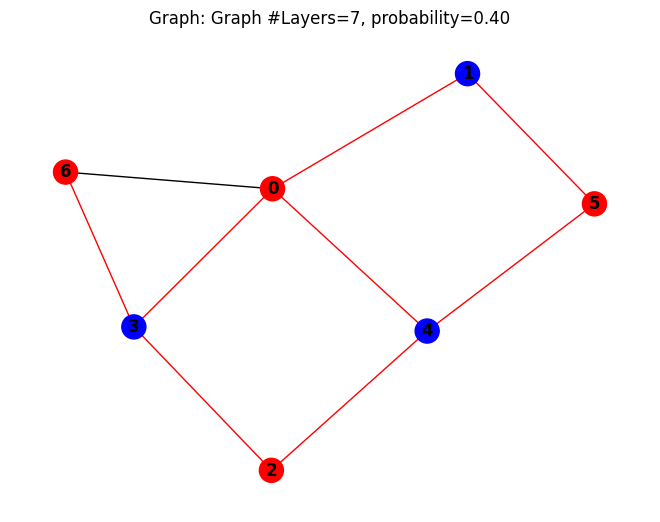

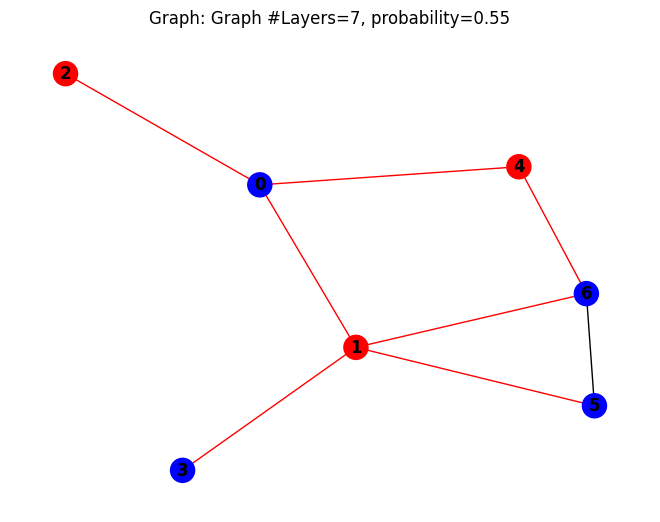

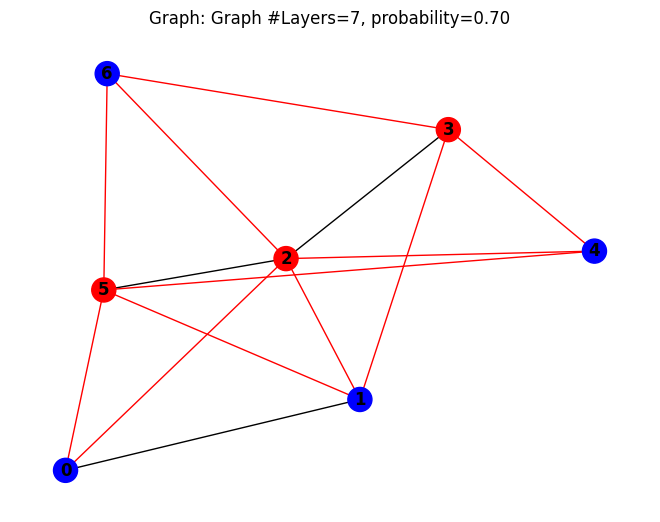

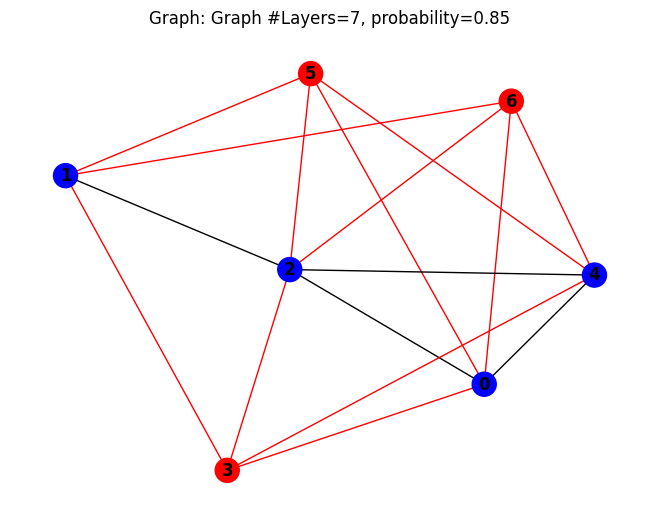

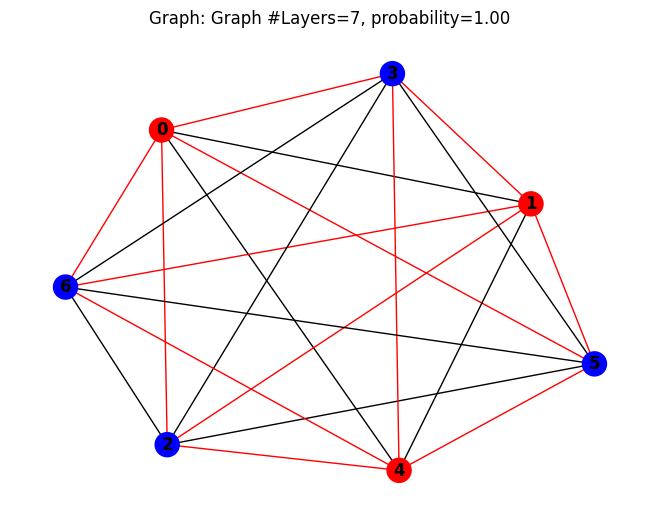

In [16]:
# Loop over graph_objs
for graph_obj in graph_objs:
    # Get the best solution for the current graph_obj
    best_solution = best_solutions[graph_obj.name][1]

    # Color the graph nodes by part
    G = graph_obj.graph
    colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
    
    # Identify the cut edges
    cut_edges = [(u, v) for u, v in G.edges() if ((best_solution[u] == '0' and best_solution[v] != '0') or (best_solution[u] != '0' and best_solution[v] == '0'))]

    cut_edge_color = 'red'
    non_cut_edge_color = 'black'
    
    # Assign edge colors based on whether they are cut edges or not
    for edge in G.edges():
        if edge in cut_edges:
            G[edge[0]][edge[1]]['color'] = cut_edge_color
        else:
            G[edge[0]][edge[1]]['color'] = non_cut_edge_color

    edge_colors = [G[edge[0]][edge[1]]['color'] for edge in G.edges()]

    # Draw the graph with colored nodes and edges
    nx.draw(G, node_color=colors, with_labels=True, font_weight='bold', edge_color=edge_colors)
    plt.title(f'Graph: {graph_obj.name}')
    plt.show()


# Attempt at calling simulator object (NOISY_SIMULATOR)

In [17]:
sim_n = QAOASimulation(SimType.NOISY_SIMULATOR)

In [18]:
opt_res_counts_dict = {}  # Create a dictionary to store results

for graph_obj in graph_objs:
    opt_res = sim_n.get_opt_params(graph_obj, graph_obj.layers)
    opt_res_counts = sim_n.run_circuit_optimal_params(opt_res, graph_obj, graph_obj.layers)
    opt_res_counts_dict[graph_obj.name] = opt_res_counts

    print(f"Graph: {graph_obj.name}")
    print("Optimal Parameters:", opt_res)
    print("Optimal Results Counts:", opt_res_counts)

# Now opt_res_counts_dict contains the results for each graph_obj



   Normal return from subroutine COBYLA

   NFVALS =  129   F =-2.794922E+00    MAXCV = 0.000000E+00
   X = 7.762021E-01   3.366125E+00   9.546543E-01   2.253792E+00   5.122127E-01
       2.294380E+00   6.059848E+00   2.770751E+00   3.734726E+00   7.137198E+00
       6.082432E+00   2.191368E+00   3.813801E+00   6.105549E+00
Graph: Graph #Layers=1, probability=0.10
Optimal Parameters:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.794921875
       x: [ 7.762e-01  3.366e+00 ...  3.814e+00  6.106e+00]
    nfev: 129
   maxcv: 0.0
Optimal Results Counts: {'1111111': 1, '1111011': 2, '0010011': 14, '1111000': 12, '1100100': 8, '0000110': 2, '0011101': 16, '0010101': 14, '0111111': 8, '1110101': 9, '0001110': 11, '0111101': 14, '0001111': 17, '1001010': 17, '1011011': 5, '0000111': 23, '1110111': 18, '1001001': 17, '1011001': 14, '0110110': 14, '0010000': 25, '1001111': 18, '1011101': 6, '0100010': 19, '1110100': 16, '0010001': 12, '0000100': 6, '1101

In [19]:
from tabulate import tabulate

# Find the best solutions for each graph_obj using opt_res_counts
best_solutions = {}
for graph_obj in graph_objs:
    opt_res_counts = opt_res_counts_dict[graph_obj.name]
    best_cut, best_solution = sim_n.best_solution(graph_obj, opt_res_counts)
    best_solutions[graph_obj.name] = (best_cut, best_solution)

# Prepare data for the table
table_data = []
for graph_obj_name, (best_cut, best_solution) in best_solutions.items():
    table_data.append([graph_obj_name, -best_cut, best_solution])

# Define table headers
headers = ["Graph Name", "Best Cut", "Best Solution"]

# Display table using tabulate
table = tabulate(table_data, headers=headers, tablefmt='grid')
print(table)


+-----------------------------------+------------+-----------------+
| Graph Name                        |   Best Cut |   Best Solution |
+===================================+============+=================+
| Graph #Layers=1, probability=0.10 |          4 |         1010110 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.25 |          3 |         1100000 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.40 |          8 |         1000011 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.55 |          8 |         1001100 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.70 |         10 |         0011100 |
+-----------------------------------+------------+-----------------+
| Graph #Layers=1, probability=0.85 |         12 |         0101011 |
+---------------------------------

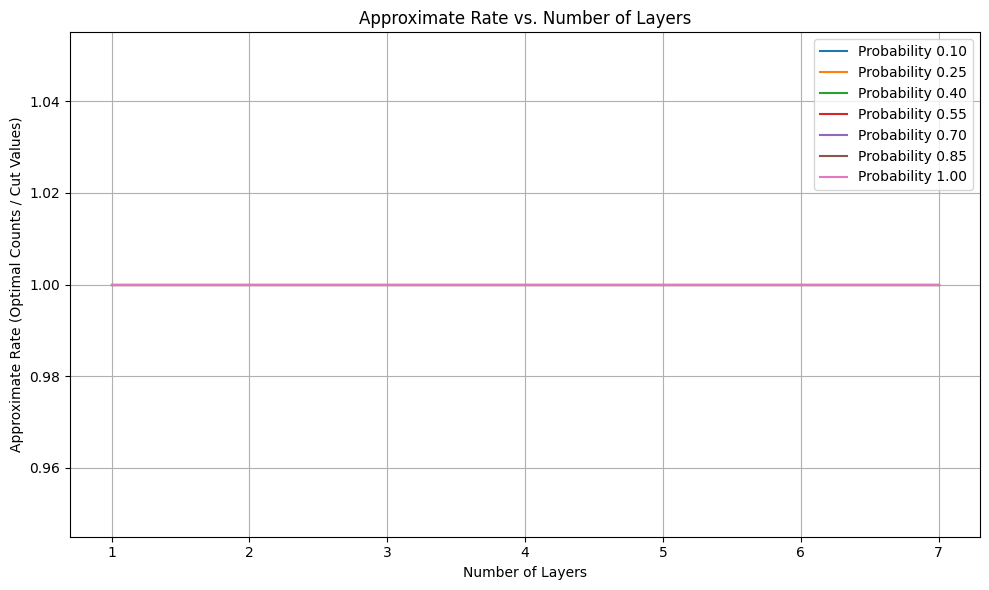

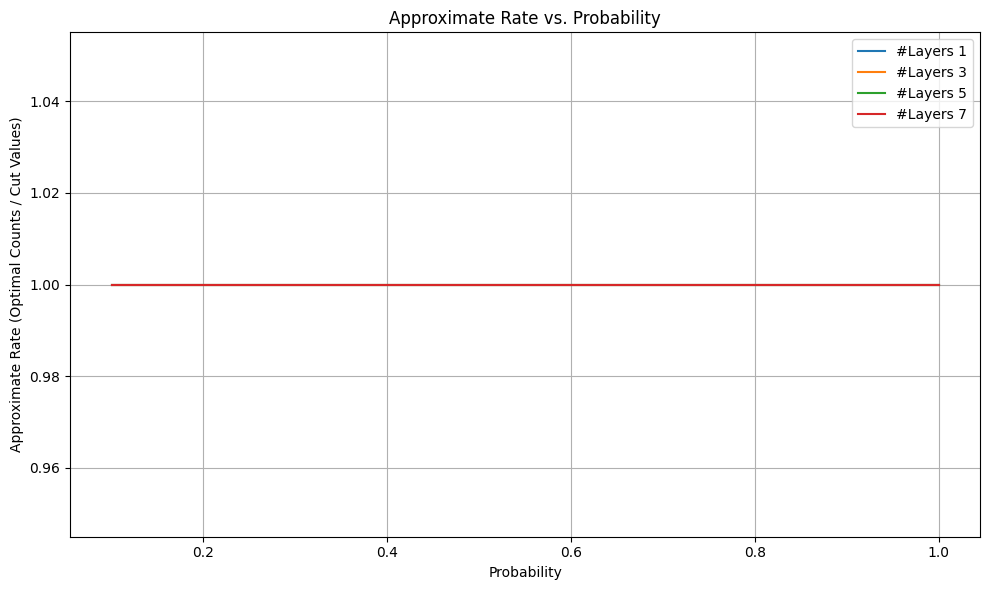

In [20]:
import matplotlib.pyplot as plt

# Separate the data for plotting
approximately_rate_layers_data = {}  # Dictionary to store approximately_rate data per probability
approximately_rate_prob_data = {}  # Dictionary to store approximately_rate data per layer
for graph_obj in graph_objs:
    prob = graph_obj.probability
    layers = graph_obj.layers
    if prob not in approximately_rate_layers_data:
        approximately_rate_layers_data[prob] = []
    if layers not in approximately_rate_prob_data:
        approximately_rate_prob_data[layers] = []
    approximately_rate_layers_data[prob].append(-best_solutions[graph_obj.name][0] / cut_values[graph_obj.name])
    approximately_rate_prob_data[layers].append(-best_solutions[graph_obj.name][0] / cut_values[graph_obj.name])

# Extract unique layers and probabilities from graph_objs
unique_layers = sorted(set(graph_obj.layers for graph_obj in graph_objs))
unique_probs = sorted(set(graph_obj.probability for graph_obj in graph_objs))

# Plot Approximate Rate vs. Number of Layers
fig1, ax1 = plt.subplots(figsize=(10, 6))
for prob in unique_probs:
    approximately_rate_list = approximately_rate_layers_data[prob]
    ax1.plot(unique_layers[:len(approximately_rate_list)], approximately_rate_list, label=f'Probability {prob:.2f}')
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Approximate Rate (Optimal Counts / Cut Values)')
ax1.set_title('Approximate Rate vs. Number of Layers')
ax1.legend()
ax1.grid(True)
plt.tight_layout()
plt.show()

# Plot Approximate Rate vs. Probability
fig2, ax2 = plt.subplots(figsize=(10, 6))
for layers in unique_layers:
    approximately_rate_list = approximately_rate_prob_data[layers]
    ax2.plot(unique_probs[:len(approximately_rate_list)], approximately_rate_list, label=f'#Layers {layers}')
ax2.set_xlabel('Probability')
ax2.set_ylabel('Approximate Rate (Optimal Counts / Cut Values)')
ax2.set_title('Approximate Rate vs. Probability')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()


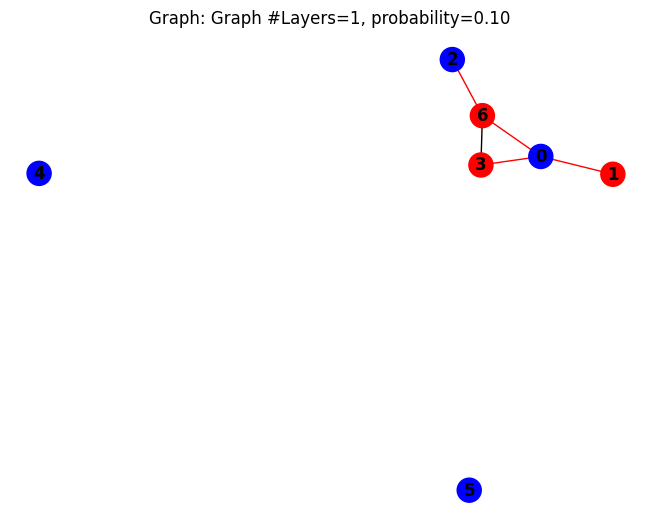

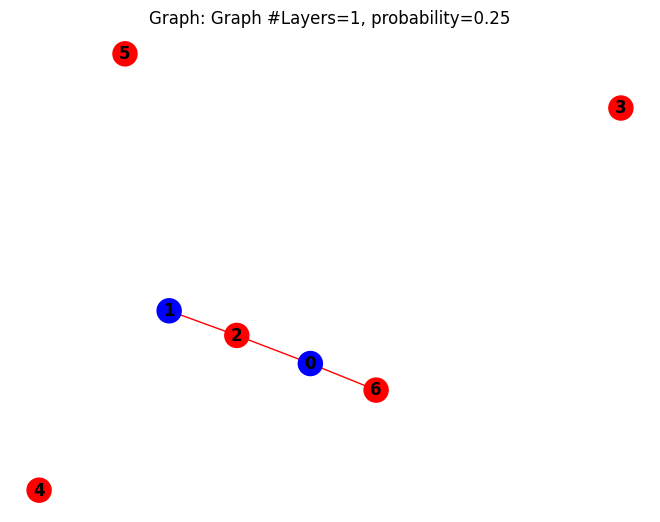

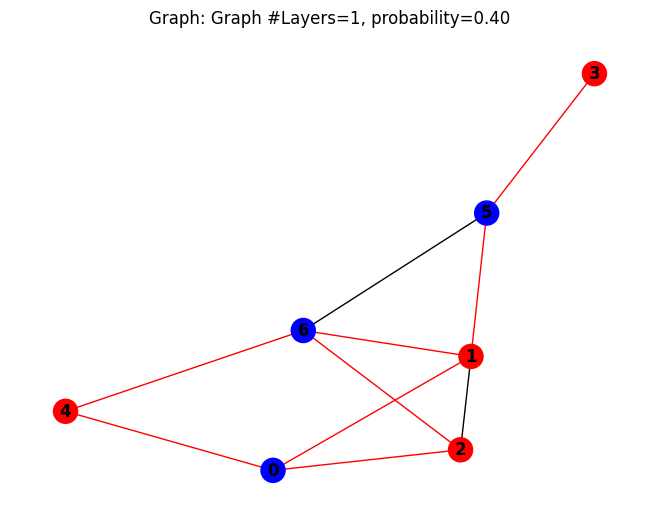

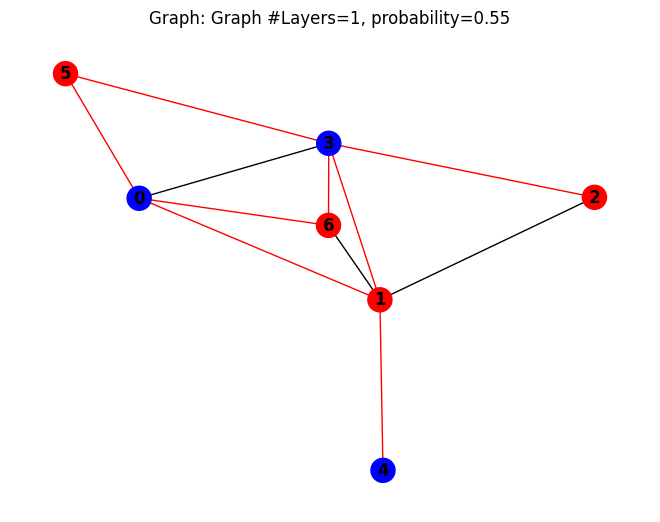

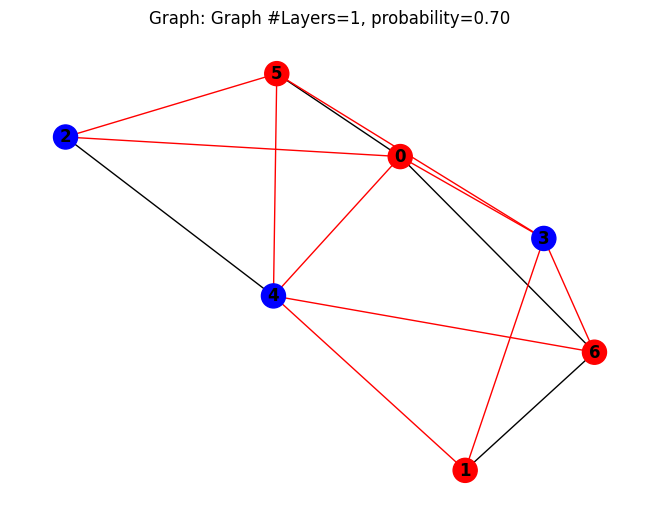

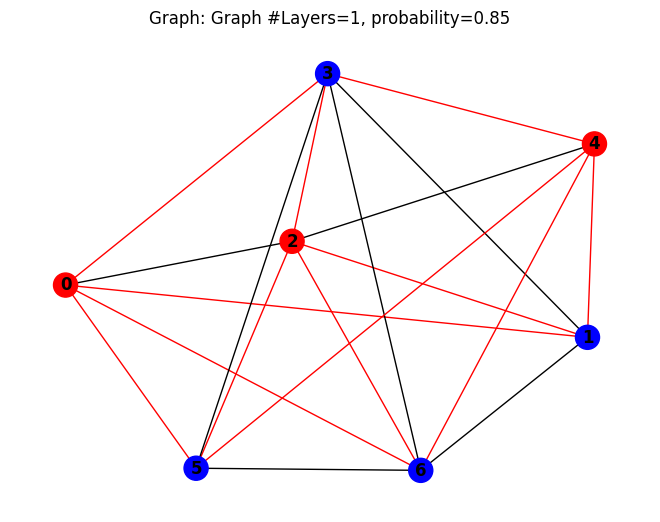

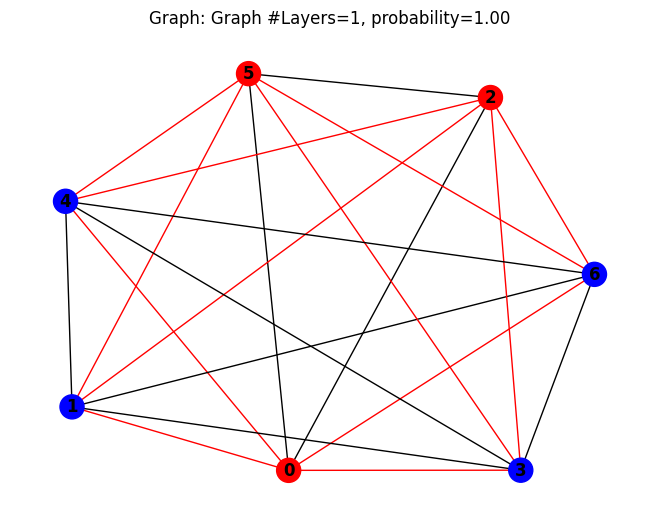

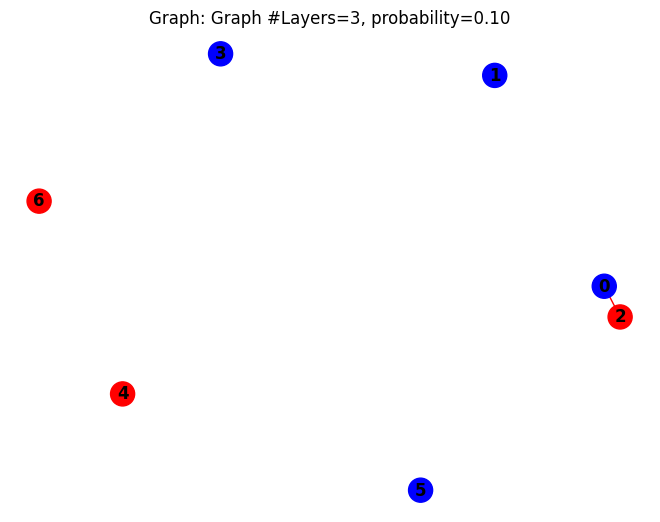

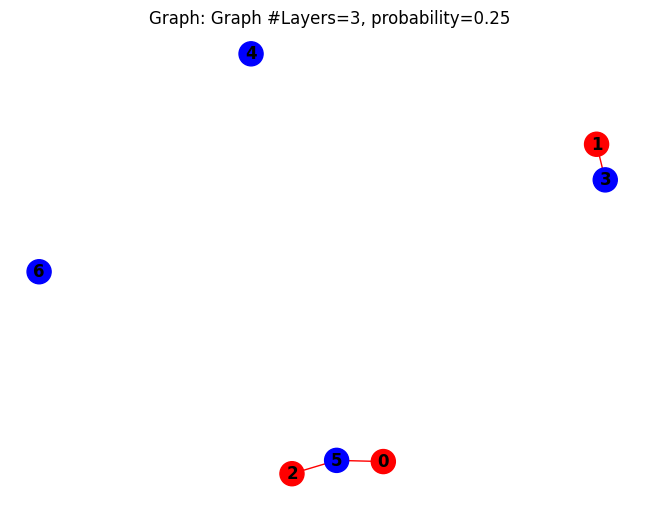

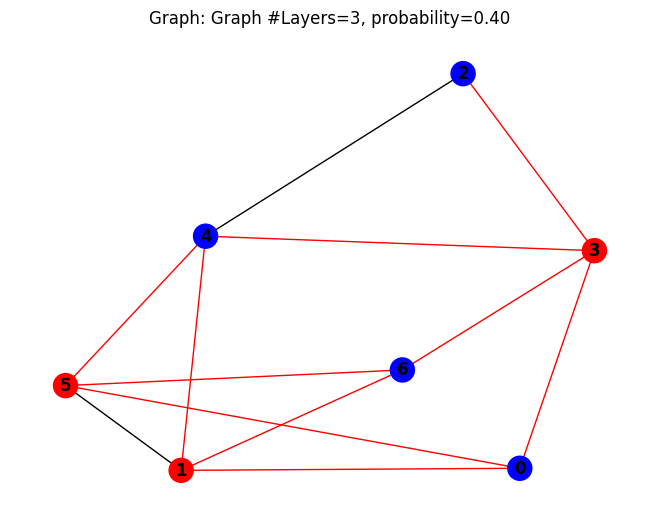

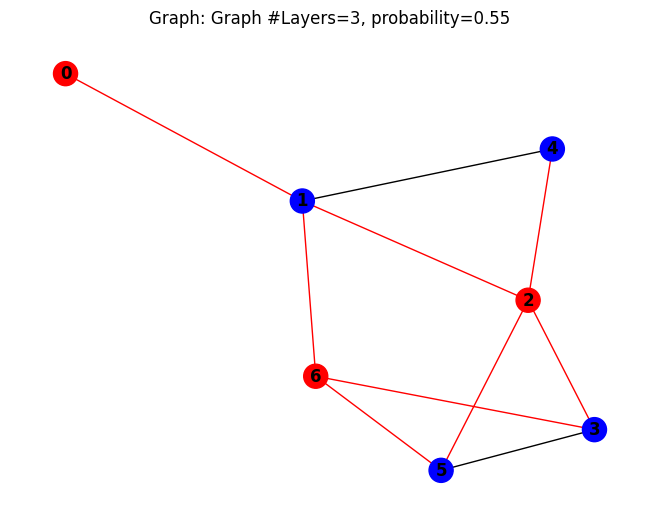

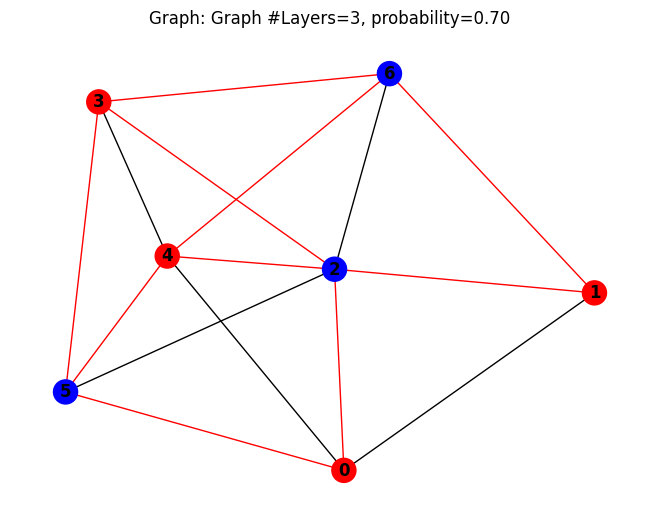

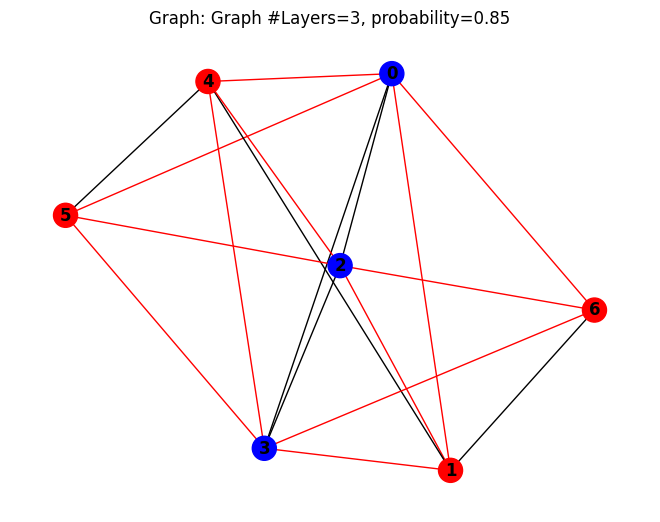

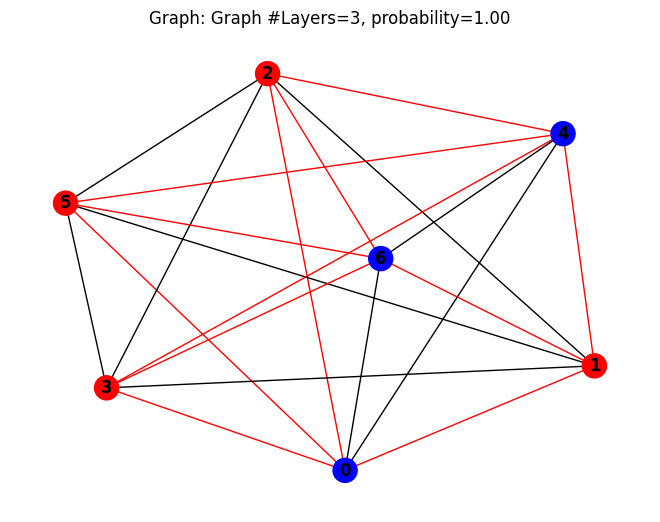

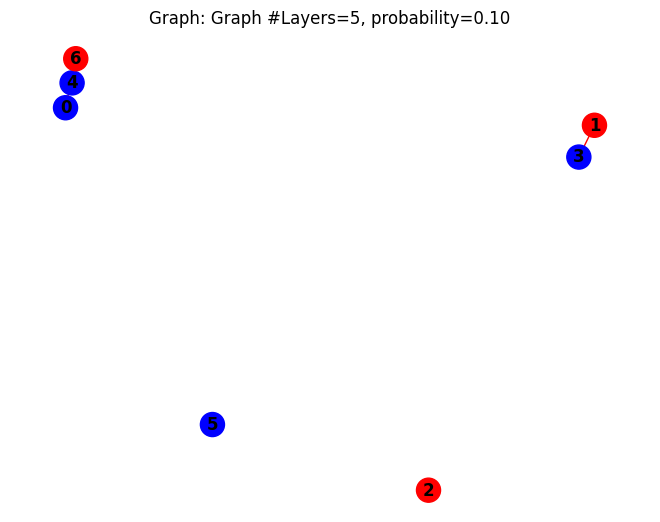

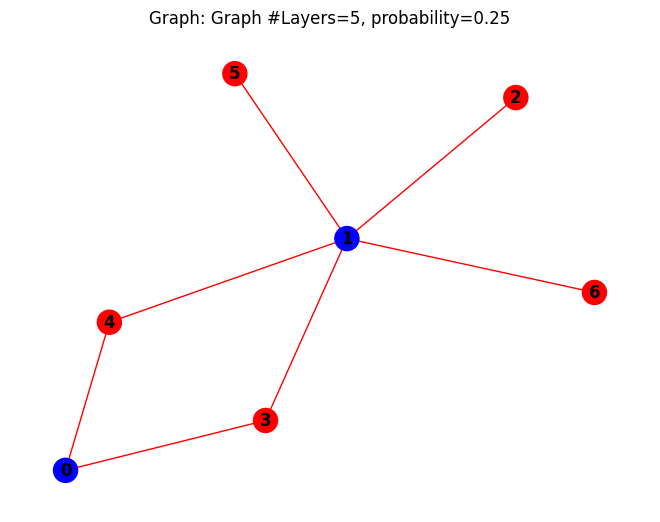

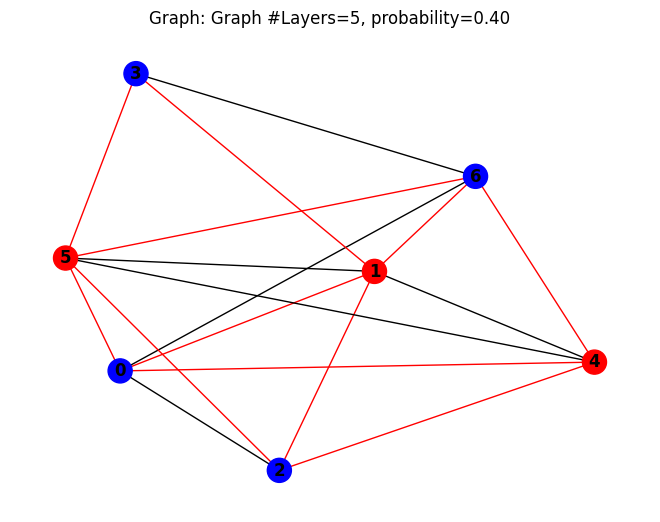

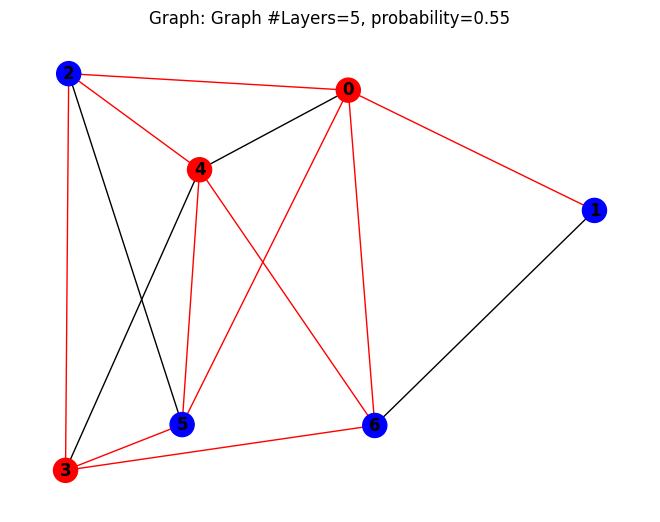

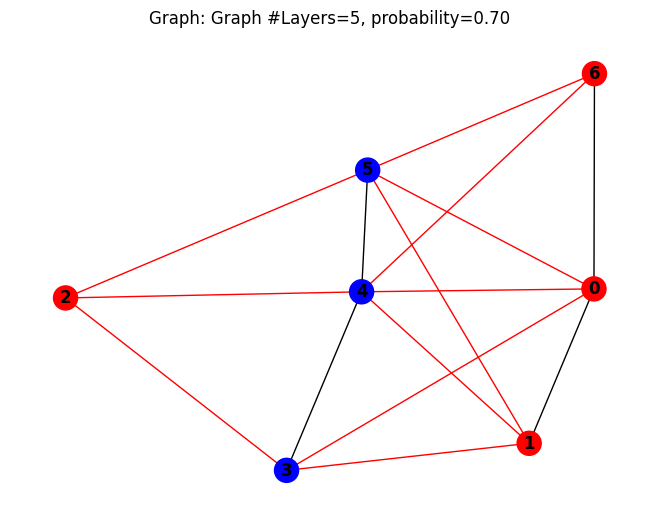

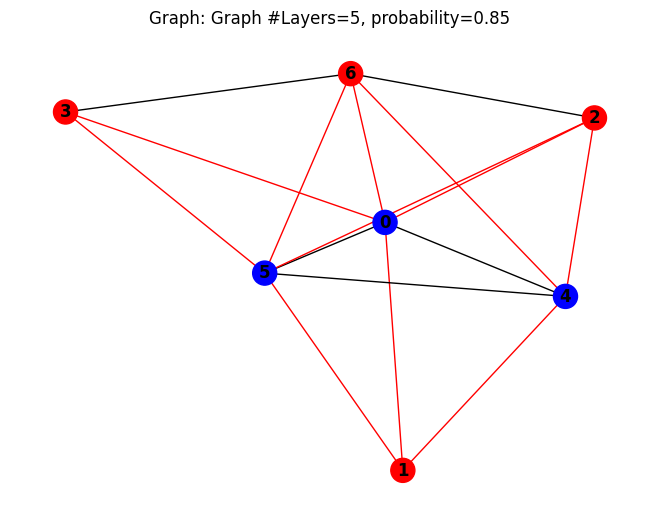

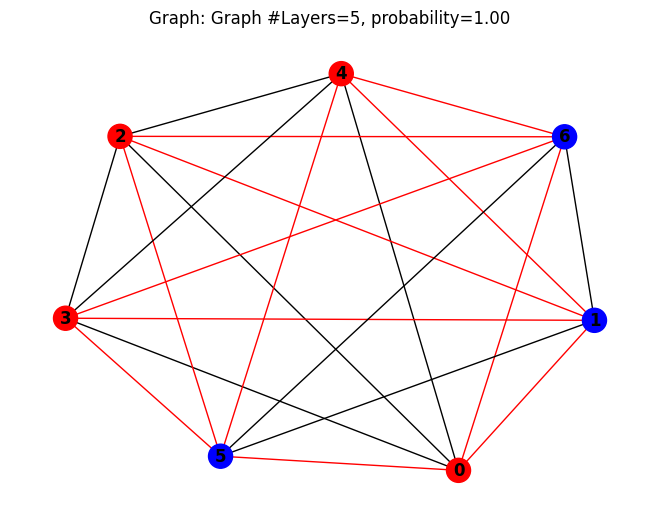

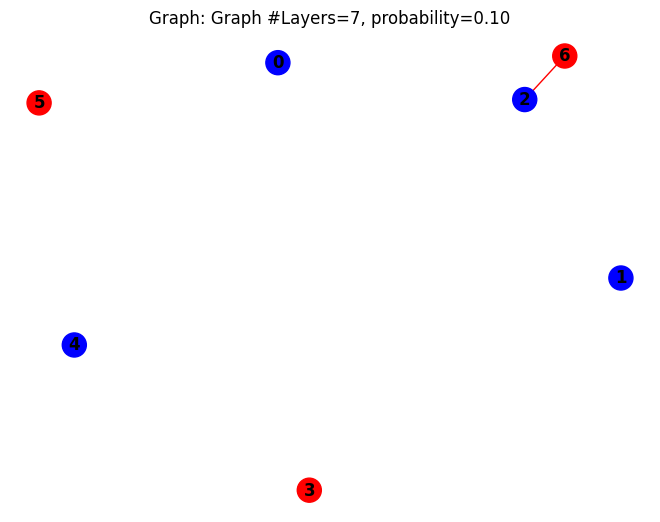

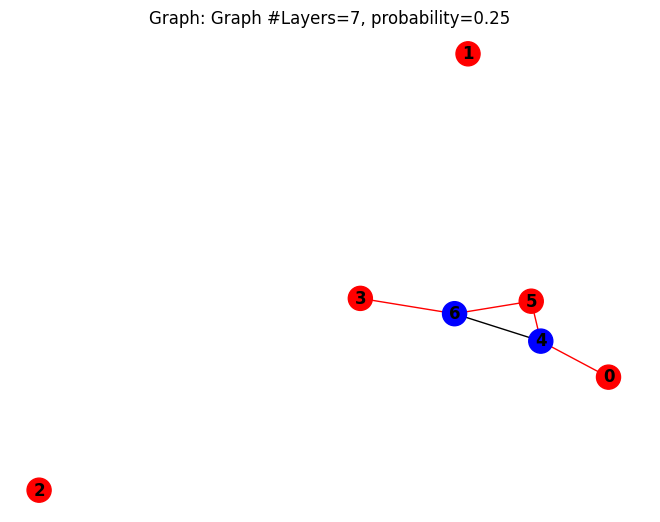

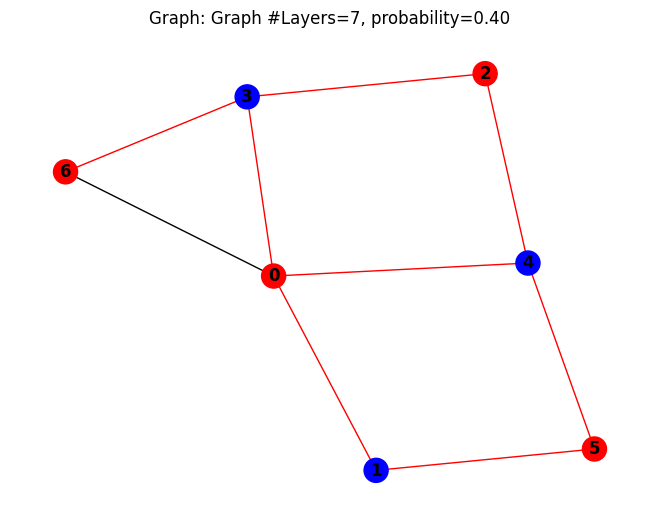

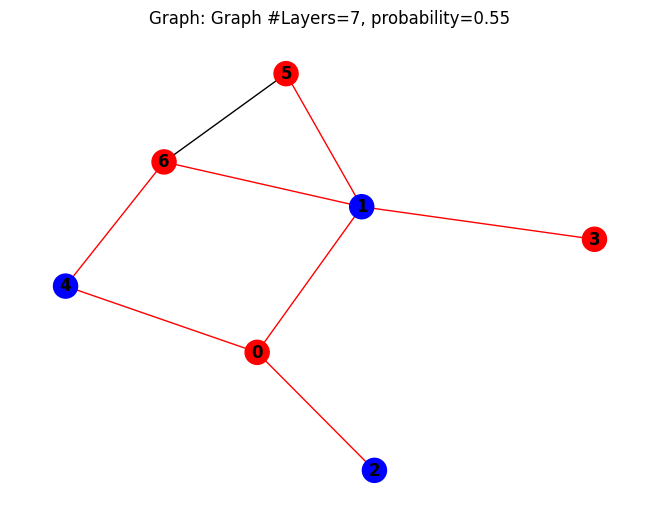

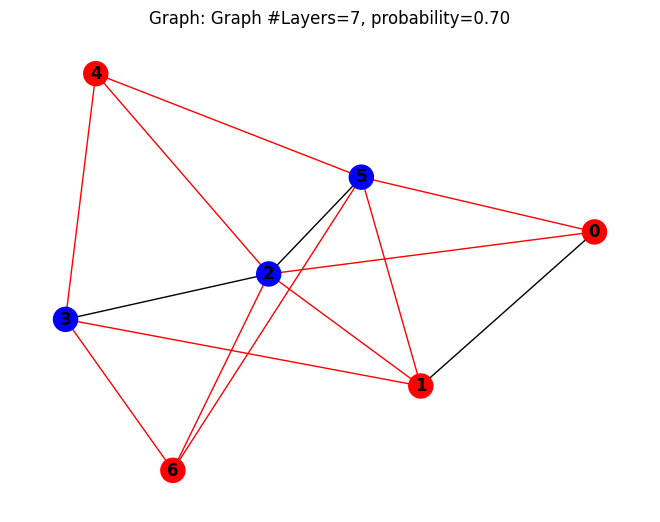

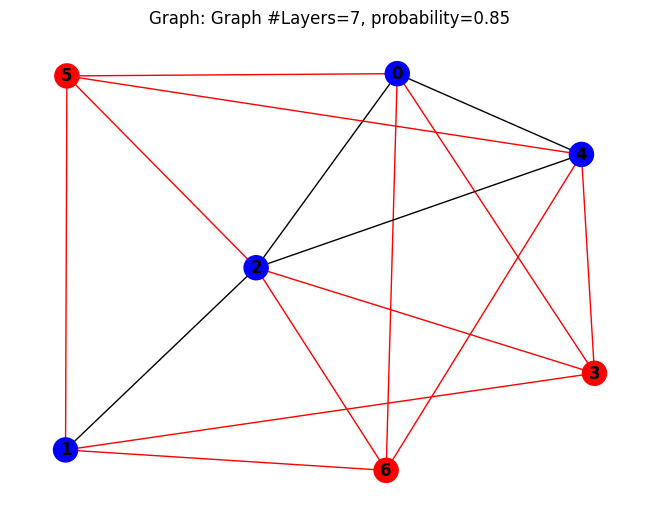

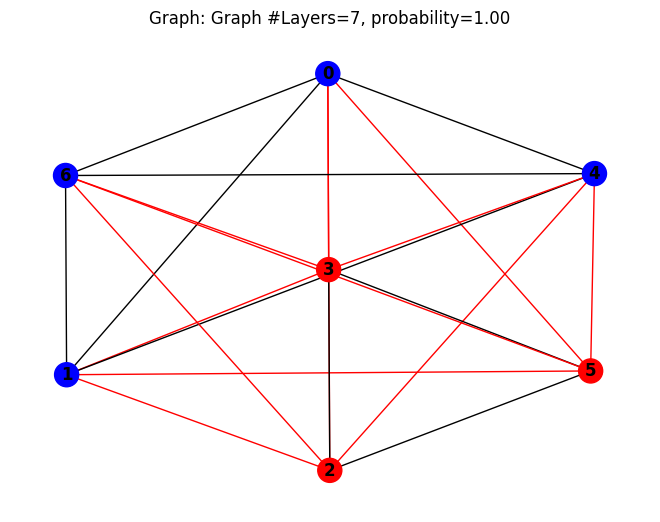

In [21]:
# Loop over graph_objs
for graph_obj in graph_objs:
    # Get the best solution for the current graph_obj
    best_solution = best_solutions[graph_obj.name][1]

    # Color the graph nodes by part
    G = graph_obj.graph
    colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
    
    # Identify the cut edges
    cut_edges = [(u, v) for u, v in G.edges() if ((best_solution[u] == '0' and best_solution[v] != '0') or (best_solution[u] != '0' and best_solution[v] == '0'))]

    cut_edge_color = 'red'
    non_cut_edge_color = 'black'
    
    # Assign edge colors based on whether they are cut edges or not
    for edge in G.edges():
        if edge in cut_edges:
            G[edge[0]][edge[1]]['color'] = cut_edge_color
        else:
            G[edge[0]][edge[1]]['color'] = non_cut_edge_color

    edge_colors = [G[edge[0]][edge[1]]['color'] for edge in G.edges()]

    # Draw the graph with colored nodes and edges
    nx.draw(G, node_color=colors, with_labels=True, font_weight='bold', edge_color=edge_colors)
    plt.title(f'Graph: {graph_obj.name}')
    plt.show()
